In [1]:
%store -r __com
print(__com)

#Combined
import pandas as pd
import seaborn as sns
import numpy as np 
import math
import matplotlib.pyplot as plt
from matplotlib import style 
import scipy.stats
import plotly.graph_objs as go
from collections import Counter
import csv
import warnings
from tqdm import tqdm_notebook as tqdm
import statsmodels.api as sm


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import GroupKFold
from sklearn import metrics
from itertools import product

import copy
import time
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import normalize
from t

In [2]:
__com

In [3]:
from translate import Translator
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, Reshape
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Embedding
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD


import gc

import lightgbm
from catboost import CatBoostRegressor
from functools import partial
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING


In [4]:
#Read datasets
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

def read_data():
    print(f'Read data')
    item_cat = pd.read_csv('item_categories.csv')
    items = pd.read_csv('items.csv')
    sales = pd.read_csv('sales_train.csv')
    submission = pd.read_csv('sample_submission.csv')
    shops = pd.read_csv('shops.csv')
    test = pd.read_csv('test.csv')
    
    print(f'item_cat shape: {item_cat.shape}')
    print(f'items shape: {items.shape}')
    print(f'sales shape: {sales.shape}')
    print(f'submission shape: {submission.shape}')
    print(f'shops shape: {shops.shape}')
    print(f'test shape: {test.shape}')

    return item_cat, items, sales, submission, shops, test

item_cat, items, sales, submission, shops, test = read_data()
pd.concat([sales.head(10), sales.tail(10)]).head(20)

Read data
item_cat shape: (84, 2)
items shape: (22170, 3)
sales shape: (2935849, 6)
submission shape: (214200, 2)
shops shape: (60, 2)
test shape: (214200, 3)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
6,02.01.2013,0,25,2565,549.00,1.0
7,04.01.2013,0,25,2572,239.00,1.0
8,11.01.2013,0,25,2572,299.00,1.0
9,03.01.2013,0,25,2573,299.00,3.0


In [ ]:
sales

# EDA

1) Plot to see if data was properly shuffled <br>
2) Shuffle y value and plot some features to see if that feature is discriminatory <br>
3) Scatterplots of train and test sets <br>
4) Correlations between features, heatmap <br>
5) Histogram of values of features <br>
6) Plot histograms of train and test set features<br>


In [ ]:
#Transform date col 
sales['date'] = pd.to_datetime(sales['date'])

#Check to see if shop_id in train and test is the same
train_unique = sales['shop_id'].nunique()
test_unique = test['shop_id'].nunique()
print(f'Number of shop_id in train {train_unique} \nNumber of shop_id in test {test_unique}')
shop_id_missing = test[~test['shop_id'].isin(sales['shop_id'])]['shop_id'].nunique()
print(f'Number of shop_id not in train {shop_id_missing}')

#Check to see if item_id in train and test is the same
train_item_unique = sales['item_id'].nunique()
test_item_unique = test['item_id'].nunique()
print(f'\nNumber of item_id in train {train_item_unique} \nNumber of item_id in test {test_item_unique}')

"""
Seems like all shops present in the test set are present in the train set, but item_id could be different, 
so we need to account for new items appearing in the test set through treating them as general category
"""

sampleshop = sales[(sales.date_block_num == 2) & 
      (sales['shop_id']==45) & 
      (sales['date']=='02.03.2014')]
sampleshop_id = sampleshop['item_id'].nunique()
print(f'\nRandom date for shop in 2014 shape {sampleshop.shape}')
print(f'Random date for shop in 2014 shape {sampleshop_id}')

testshop = test[(test['shop_id']==45)]
testshop_id = testshop['item_id'].nunique()
print(f'\nTest set shop shape {testshop.shape}')
print(f'Test set shop items shape {testshop_id}')

"""
Seems like the test set lists out ALL the item_ids while the train set only lists out the ids that have item counts, 
or are specific to that shop, we need to plot to see if the item_ids fluctuate for a store alot 
"""

sampleshop.head(10)

In [ ]:
index_cols = ['shop_id', 'date_block_num']

train = sales.copy()
train['date'] = pd.to_datetime(train['date'], format = "%d.%m.%Y")
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day

train_agg = train.groupby(index_cols, 
                          as_index = False).agg({'item_cnt_day':'sum', 'year':'first'})
train_agg = train_agg.groupby(['shop_id','year'], 
                          as_index = False).agg({'item_cnt_day':'mean'})
train_agg.sort_values(['item_cnt_day', 'year'],ascending = False, inplace = True)
train_agg = train_agg.groupby('shop_id', as_index = False).apply(lambda x: x.iloc[:3])

fig, ax = plt.subplots(3, 1, figsize = (14, 9))

for i, yr in enumerate(train['year'].unique()):
    temp = train_agg[train_agg['year'] == yr]
    ax[i] = sns.barplot(x = 'shop_id', y = 'item_cnt_day', data = temp, orient = 'v', ax = ax[i])
    ax[i].set_title(f'{yr} sales by shop', fontsize = 18)
    
plt.tight_layout()
plt.show()

In [ ]:
#Plot to see most popular items acrss 3 years
index_cols = ['item_id', 'date_block_num']
train_agg = train.groupby(index_cols, 
                          as_index = False).agg({'item_cnt_day':'sum', 'year':'first'})
train_agg = train_agg.groupby(['item_id','year'], 
                          as_index = False).agg({'item_cnt_day':'mean'})
train_agg = train_agg.groupby('year', 
                              as_index = False).apply(lambda x: x.sort_values('item_cnt_day', 
                                                                              ascending = False).iloc[:25])
fig, ax = plt.subplots(3, 1, figsize = (14, 9))
for i, yr in enumerate(train['year'].unique()):
    temp = train_agg[train_agg['year'] == yr]
    ax[i] = sns.barplot(x = 'item_id', y = 'item_cnt_day', data = temp, orient = 'v', ax = ax[i])
    ax[i].set_title(f'{yr} top 50 sales by item', fontsize = 18)


plt.tight_layout()    
plt.show()


In [ ]:
"""
Plot one product and one shop across time
"""
#Find this damn product 
all_data = pd.read_pickle('AML Data Comp all_data_translated 200715.pkl')
graph_shop = []
shop_id_agg = all_data.groupby(['shop_id', 'month'], as_index = False).agg({'target':'sum'})
for i, group in shop_id_agg.groupby('shop_id'):
    if group['month'].nunique() == 12:
        graph_shop.append(group['shop_id'].iloc[0])

top7 = shop_id_agg[shop_id_agg['shop_id'].isin(graph_shop[:7])]

fig, ax = plt.subplots(8, 1, figsize = (12, 9), sharex = True)
for idx, x in enumerate(top7['shop_id'].unique()):
    temp = top7[top7['shop_id'] == x]
    ax[idx] = sns.lineplot(x = 'month', y = 'target', data = temp, ax = ax[idx], color = 'navy')
    ax[idx].set_title(f'shop_id {x}')
shop_id_agg = shop_id_agg[shop_id_agg['shop_id'].isin(graph_shop)].groupby('month', as_index = False).agg({'target':'mean'})
ax[7] = sns.lineplot(x = 'month', y = 'target', data = shop_id_agg, ax = ax[7], linewidth = 3)    
ax[7].set_title('shop_id overall')

plt.tight_layout()
plt.show()

In [ ]:
#Plot date_block_num over time
shop_id_agg = all_data.groupby('date_block_num', as_index = False).agg({'target':'sum'})

fig, ax = plt.subplots(1, 1, figsize = (12, 5))
ax = sns.lineplot(x = 'date_block_num', y = 'target', data = shop_id_agg,  ax = ax,linewidth = 2)

plt.tight_layout()
plt.show()

# Feature engineering
1) Target encoding  <br>
2) Feature interactions with PCA  <br>
3) KNN statistics  <br>
4) Shop means<br>
5) Price change from previous period <br>
6) Check first 2 digits of the item ID for categorical <br>

In [5]:
#Create combined dataset aggregated to the month level for each item present in each month
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month, cartesian product of shop_id and item_id
grid = [] 

for block_num in sales['date_block_num'].unique():
    cur_shops = sales[sales['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales[sales['date_block_num']==block_num]['item_id'].unique()
    cart_prod = np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32')
    grid.append(cart_prod)

#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

#get aggregated values for (shop_id, item_id, month)
sales['date'] = pd.to_datetime(sales['date'], format = "%d.%m.%Y")
sales['year'] = sales['date'].dt.year
sales['month'] = sales['date'].dt.month
sales = sales[sales['item_cnt_day'] < 2000]

date_block_month = sales.groupby('date_block_num').agg({'month':'first'}).to_dict()['month']
date_block_month[34] = 11

date_block_year = sales.groupby('date_block_num').agg({'year':'first'}).to_dict()['year']
date_block_year[34] = 2015

gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})

#fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
#join aggregated data to the grid

#Groupby date and item to get price, and concat with test set group34 price
sales = sales[sales['item_price'] < 300000]
group = sales.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['item_price']
group.reset_index(inplace=True)
group34 = group.drop_duplicates('item_id', keep ='last')
group34['date_block_num']= 34
group = pd.concat([group, group34], axis = 0)

# price_dict = sales.drop_duplicates('item_id', 
#                                       keep='last').set_index('item_id')[['item_price']].to_dict()['item_price']

all_data = pd.merge(grid,gb,how='left',on=index_cols).fillna(0)

#sort the data
all_data.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

"""
Concat the test set in, cus tactics bitch
"""
#Concat the test set
test['date_block_num'] = all_data['date_block_num'].max() + 1
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

# test['item_price'] = np.zeros(test.shape[0])
cols = test.columns

#Concat test and train cus fucking tactics
all_data = pd.concat([all_data, test], ignore_index=True, sort=False, keys=cols)
all_data = pd.merge(all_data, group, on=['date_block_num','item_id'], how = 'left')

# all_data['item_price'] = all_data['item_id'].map(price_dict)
                                               
all_data.drop('ID', axis = 1, inplace = True)


#Fix shop_ids
fix_shops = {0:57, 1:58, 10:11}
all_data['shop_id'] = np.where(all_data['shop_id'].isin(fix_shops.keys()), 
                               all_data['shop_id'].map(fix_shops), 
                              all_data['shop_id'])


#Limit item price and item cnt
# train = train[train.item_price<100000]
# train = train[train.item_cnt_day<1001]

#Create merge between item category and items datasets 
all_items = pd.merge(items, item_cat, how="left", on=['item_category_id'])
all_data = pd.merge(all_data, all_items, how="left", on=['item_id'])

item_cat_price_dict = all_data.groupby('item_category_id').agg({'item_price':'mean'}).to_dict()['item_price']
all_data['item_price'] = np.where(all_data['item_price'].isnull(), 
                                  all_data['item_category_id'].map(item_cat_price_dict), 
                                all_data['item_price'])

#Fix negative prices 
all_data['item_price'] = np.where(all_data['item_price']<0, 
                                  all_data['item_category_id'].map(item_cat_price_dict),
                                  all_data['item_price'])

all_data.fillna(0, inplace = True)

all_data['month'] = all_data['date_block_num'].map(date_block_month)
all_data['year'] = all_data['date_block_num'].map(date_block_year)

all_data['revenue'] = all_data['item_price'] * all_data['target']
all_data['target'] = np.clip(all_data['target'], 0, 20)

# all_data['key1'] = all_data['shop_id'].astype(str) + "_" + all_data['date_block_num'].astype(str)
# all_data['key2'] = all_data['shop_id'].astype(str) + \
#                     "_" + all_data['date_block_num'].astype(str) + \
#                     "_" + all_data['item_category_id'].astype(str)

# all_data['key3'] = all_data['shop_id'].astype(str) + \
#                     "_" + all_data['date_block_num'].astype(str) + \
#                     "_" + all_data['item_id'].astype(str)

print(all_data.isnull().sum())
all_data.to_pickle('AML Data Comp all_data 200726.pkl', protocol = 2)

all_data.tail(100)

shop_id               0
item_id               0
date_block_num        0
target                0
item_price            0
item_name             0
item_category_id      0
item_category_name    0
month                 0
year                  0
revenue               0
dtype: int64


,shop_id,item_id,date_block_num,target,item_price,item_name,item_category_id,item_category_name,month,year,revenue
11127950,45.0,18707,34,0.0,149.000000,СКАЗКА О ЦАРЕ САЛТАНЕ (Liz) (Регион),40,Кино - DVD,11,2015,0.0
11127951,45.0,17482,34,0.0,399.000000,ПРОМЕТЕЙ (BD),37,Кино - Blu-Ray,11,2015,0.0
11127952,45.0,14972,34,0.0,554.505686,Манга Переживая юность,47,"Книги - Комиксы, манга",11,2015,0.0
11127953,45.0,15472,34,0.0,549.000000,Мягкая игрушка Том и Джерри Том 30 см,63,Подарки - Мягкие игрушки,11,2015,0.0
11127954,45.0,16034,34,0.0,499.000000,Настольная игра Black Stories 3 (Темные истории),65,Подарки - Настольные игры (компактные),11,2015,0.0
11127955,45.0,13543,34,0.0,2999.000000,Конструктор электронный Матрешка Х,67,Подарки - Развитие,11,2015,0.0
11127956,45.0,13403,34,0.0,39990.500000,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",16,Игровые консоли - XBOX ONE,11,2015,0.0
11127957,45.0,11758,34,0.0,99.000000,ЗОЛОТОЙ КОМПАС WB (регион),40,Кино - DVD,11,2015,0.0
11127958,45.0,11181,34,0.0,99.000000,ДОМОВЕНОК КУЗЯ сб.м/ф (регион),40,Кино - DVD,11,2015,0.0
11127959,45.0,11236,34,0.0,399.000000,ДРУЗЬЯ СЕЗОН 2,40,Кино - DVD,11,2015,0.0


In [6]:
"""
Bypass the consolidation of the infinity stones
"""
all_data = pd.read_pickle('AML Data Comp all_data 200726.pkl')
print(all_data.shape)
all_data.tail(10)

(11128050, 11)


,shop_id,item_id,date_block_num,target,item_price,item_name,item_category_id,item_category_name,month,year,revenue
11128040,45.0,3280,34,0.0,349.000000,FARMER MYLENE Best Of 2001-2011,55,Музыка - CD локального производства,11,2015,0.0
11128041,45.0,4393,34,0.0,698.000000,"LEGO Хоббит [PS Vita, русские субтитры]",22,Игры - PSVita,11,2015,0.0
11128042,45.0,4352,34,0.0,1299.000000,"LEGO Marvel Super Heroes [PS Vita, русские суб...",22,Игры - PSVita,11,2015,0.0
11128043,45.0,18049,34,0.0,274.000000,Резинки для плетения силиконовые Неон желтый N...,70,Подарки - Сувениры (в навеску),11,2015,0.0
11128044,45.0,18027,34,0.0,265.666667,Резинки для плетения Коллекция Средневековья Н...,70,Подарки - Сувениры (в навеску),11,2015,0.0
11128045,45.0,18454,34,0.0,99.000000,СБ. Союз 55,55,Музыка - CD локального производства,11,2015,0.0
11128046,45.0,16188,34,0.0,1359.000000,Настольная игра Нано Кёрлинг,64,Подарки - Настольные игры,11,2015,0.0
11128047,45.0,15757,34,0.0,229.000000,НОВИКОВ АЛЕКСАНДР Новая коллекция,55,Музыка - CD локального производства,11,2015,0.0
11128048,45.0,19648,34,0.0,89.100000,ТЕРЕМ - ТЕРЕМОК сб.м/ф (Регион),40,Кино - DVD,11,2015,0.0
11128049,45.0,969,34,0.0,198.000000,3 ДНЯ НА УБИЙСТВО (BD),37,Кино - Blu-Ray,11,2015,0.0


In [7]:
"""
Nikolai to Nicholas
"""
#Translate names to english for better understanding
def translate_russian(df):
    #Translate columns from dutch to english
    cols_to_translate = ['item_category_name']
    
    unique_list = []
    for column in df.columns: 

        if column in cols_to_translate:
            uniques = df[column].unique()
            translated = {}

            for element in uniques:
                translator = Translator(from_lang = 'ru', to_lang = 'en')
                try:
                    t_element = translator.translate(element)
                except:
                    print(element)

                translated[element] = t_element

            unique_list.append(translated)
    
    for index, column in enumerate(cols_to_translate): 
        if column in df.columns:
            df[column + "_trans"] = df[column].map(unique_list[index])
    
    return df

# all_data = translate_russian(all_data)

#Bypass translation using map
transdict = pd.read_pickle('AML_item_cat_dict.pkl')
transdict = transdict.set_index('item_category_name').to_dict()['item_category_name_trans']
all_data['item_category_name'] = all_data['item_category_name'].map(transdict)
all_data.to_pickle('AML Data Comp all_data_translated 200726.pkl')

print(all_data.isnull().sum())
all_data.tail(10)

shop_id               0
item_id               0
date_block_num        0
target                0
item_price            0
item_name             0
item_category_id      0
item_category_name    0
month                 0
year                  0
revenue               0
dtype: int64


,shop_id,item_id,date_block_num,target,item_price,item_name,item_category_id,item_category_name,month,year,revenue
11128040,45.0,3280,34,0.0,349.000000,FARMER MYLENE Best Of 2001-2011,55,Music - Local Production CD,11,2015,0.0
11128041,45.0,4393,34,0.0,698.000000,"LEGO Хоббит [PS Vita, русские субтитры]",22,Games - PSVita,11,2015,0.0
11128042,45.0,4352,34,0.0,1299.000000,"LEGO Marvel Super Heroes [PS Vita, русские суб...",22,Games - PSVita,11,2015,0.0
11128043,45.0,18049,34,0.0,274.000000,Резинки для плетения силиконовые Неон желтый N...,70,Gifts - Souvenirs (in bulk),11,2015,0.0
11128044,45.0,18027,34,0.0,265.666667,Резинки для плетения Коллекция Средневековья Н...,70,Gifts - Souvenirs (in bulk),11,2015,0.0
11128045,45.0,18454,34,0.0,99.000000,СБ. Союз 55,55,Music - Local Production CD,11,2015,0.0
11128046,45.0,16188,34,0.0,1359.000000,Настольная игра Нано Кёрлинг,64,Gifts - Board Games,11,2015,0.0
11128047,45.0,15757,34,0.0,229.000000,НОВИКОВ АЛЕКСАНДР Новая коллекция,55,Music - Local Production CD,11,2015,0.0
11128048,45.0,19648,34,0.0,89.100000,ТЕРЕМ - ТЕРЕМОК сб.м/ф (Регион),40,Cinema - DVD,11,2015,0.0
11128049,45.0,969,34,0.0,198.000000,3 ДНЯ НА УБИЙСТВО (BD),37,Cinema - Blu-ray,11,2015,0.0


In [11]:
"""
Bypass that beastly translation segment
"""
all_data = pd.read_pickle('AML Data Comp all_data_translated 200726.pkl')
all_data.head(20)

,shop_id,item_id,date_block_num,target,item_price,item_name,item_category_id,item_category_name,month,year,revenue
0,57.0,19,0,0.0,28.000000,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,Cinema - DVD,1,2013,0.000000
1,57.0,27,0,0.0,2325.000000,"007 Legends [PS3, русская версия]",19,Games - PS3,1,2013,0.000000
2,57.0,28,0,0.0,549.000000,"007 Legends [PС, Jewel, русская версия]",30,PC Games - Standard Editions,1,2013,0.000000
3,57.0,29,0,0.0,2397.500000,"007 Legends [Xbox 360, русская версия]",23,Xbox 360 Games,1,2013,0.000000
4,57.0,32,0,6.0,338.110349,1+1,40,Cinema - DVD,1,2013,2028.662095
5,57.0,33,0,3.0,488.517241,1+1 (BD),37,Cinema - Blu-ray,1,2013,1465.551724
6,57.0,34,0,0.0,140.888889,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,Cinema - DVD,1,2013,0.000000
7,57.0,35,0,1.0,390.709091,10 ЛЕТ СПУСТЯ,40,Cinema - DVD,1,2013,390.709091
8,57.0,40,0,0.0,219.250000,100 Best classical melodies (mp3-CD) (Digipack),57,Music - MP3,1,2013,0.000000
9,57.0,41,0,0.0,222.555556,100 Best relax melodies (mp3-CD) (CD-Digipack),57,Music - MP3,1,2013,0.000000


In [12]:
"""
Get higher level categorical features just in case
"""
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops['city'] = shops['city'].str.replace('!', '')
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops_map = shops.set_index('shop_id')['city_code'].to_dict()

#Map the city code on to 
all_data['city_code'] = all_data['shop_id'].map(shops_map)

#Map main categories
item_cat_map = all_data.drop_duplicates('item_category_id')[['item_category_id','item_category_name']]
item_cat_map['item_cat_main'] = item_cat_map['item_category_name'].str.split(' - ').map(lambda x:x[0])
item_cat_map['item_cat_main_code'] = LabelEncoder().fit_transform(item_cat_map['item_cat_main'])
item_cat_map = item_cat_map.set_index('item_category_id')[['item_cat_main_code']].to_dict()['item_cat_main_code']

all_data['item_cat_main'] = all_data['item_category_id'].map(item_cat_map)

#Map sub categories
item_cat_sub_map = all_data.drop_duplicates('item_category_id')[['item_category_id','item_category_name']]
item_cat_sub_map['item_cat_sub'] = item_cat_sub_map['item_category_name'].str.split(' - ').map(lambda x:x[1] if len(x)>1 else x[0])
item_cat_sub_map['item_cat_sub_code'] = LabelEncoder().fit_transform(item_cat_sub_map['item_cat_sub'])
item_cat_sub_map = item_cat_sub_map.set_index('item_category_id')[['item_cat_sub_code']].to_dict()['item_cat_sub_code']

all_data['item_cat_sub'] = all_data['item_category_id'].map(item_cat_sub_map)




In [ ]:
# """
# Deep categorical embedding of shop_id and item_category_id
# """
# target = ['target']
# embed_cols = ['shop_id','item_category_id']

# def preproc(X_train, df):
#     input_list_train = []
#     input_list_val = []
#     input_list_test = []
    
#     for c in embed_cols:
#         raw_vals = np.unique(X_train[c])
#         val_map = {}
#         print(raw_vals)
#         for i in range(len(raw_vals)):
#             val_map[raw_vals[i]] = i
#         input_list_train.append(X_train[c].map(val_map).values)
#         df[c + '_embed_id'] = df[c].map(val_map)
    
#     return input_list_train, df

# input_models = []
# output_embeddings = []
# for categorical_var in embed_cols:
#     #rename categorical variables which will be used in keras embedding layer
#     cat_emb_name = categorical_var.replace(" ", "") + "_Embedding" 
#     #define embedding size
#     no_of_unique_cat = all_data[categorical_var].nunique()
#     embedding_size = int(min(np.ceil((no_of_unique_cat)/2.5), 30)) 
#     #one embedding layer for each categorical variable
#     input_model = Input(shape = (1,))
#     output_model = Embedding(no_of_unique_cat, embedding_size, name = cat_emb_name)(input_model)
#     output_model = Reshape(target_shape = (embedding_size,))(output_model)
    
#     #appending all the categorical inputs
#     input_models.append(input_model)
    
#     #appending all the embeddings
#     output_embeddings.append(output_model)
    
# #concat altogether
# if len(output_embeddings) >1: 
#     output = Concatenate()(output_embeddings)
# else: 
#     output = output_embeddings[0]
    
# output = Dense(1024, kernel_initializer = 'uniform')(output)
# output = Activation('relu')(output)
# output = Dropout(0.4)(output)
# output = Dense(512, kernel_initializer = 'uniform')(output)
# output = Activation('relu')(output)
# output = Dropout(0.3)(output)
# output = Dense(1, activation = 'linear')(output)
# model = Model(inputs = input_models, outputs = output)
# #model.compile(loss = 'mean_squared_error', optimizer = 'Adam', metrics = ['mse', 'mape'])
# opt = SGD(lr=0.01, momentum=0.9)
# model.compile(loss = "mse", optimizer = "adam", metrics = ['mse'])
# model.summary()

# embed_df = all_data[all_data['date_block_num']<34].groupby(embed_cols +['date_block_num'], as_index = False).agg({'target':'sum'})
# X_train_list, all_data = preproc(embed_df[embed_cols], all_data)
# model.fit(x = X_train_list, y=embed_df['target'].as_matrix(), epochs = 10, batch_size = 512, verbose = 2)

# for col in embed_cols:
#     weight_embed = col + '_Embedding'
#     weight_df = pd.DataFrame(model.get_layer(weight_embed).get_weights()[0]).reset_index()
#     for i in weight_df.columns:
#         if i != 'index':
#             sub_dict = dict(zip(weight_df['index'],weight_df[i]))
#             col_name_label = col
#             col_name = col + '_' + str(i)
#             all_data[col_name] = all_data[col_name_label + '_embed_id'].map(sub_dict).values
#     all_data.drop([col + '_embed_id'], axis = 1, inplace = True)
    
# drop_cols = embed_cols
# # all_data = all_data.drop(columns=drop_cols, axis=1)
# all_data.to_pickle('AML Data Comp all_data 200721_trans_deepenc.pkl')
# all_data.tail(100)

In [ ]:
# """
# Bypass that beastly deep encoding section
# """
# all_data = pd.read_pickle('AML Data Comp all_data 200721_trans_deepenc.pkl')
# print(all_data.shape)
# all_data.tail(100)

In [13]:
"""
Target encode this shit
"""
#Use expanding mean target encoding
gmean = all_data.target.mean()
cumsum = all_data.groupby('item_id')['target'].cumsum() - all_data['target']
cumcnt = all_data.groupby('item_id')['target'].cumcount()
all_data['item_target_enc'] = cumsum / cumcnt
all_data['item_target_enc'].fillna(gmean, inplace = True)

del cumsum 
del cumcnt

encoded_feature = all_data['item_target_enc'].values
corr = np.corrcoef(all_data['target'].values, encoded_feature)[0][1]

cat_month_cols = ['item_category_name', 'month']
catmth_encoded = all_data.groupby(cat_month_cols)['target'].mean().reset_index().rename(columns = {'target':'item_catmth_encode'})
all_data = all_data.merge(catmth_encoded,how='left')


del encoded_feature

all_data.tail(50)

,shop_id,item_id,date_block_num,target,item_price,item_name,item_category_id,item_category_name,month,year,revenue,city_code,item_cat_main,item_cat_sub,item_target_enc,item_catmth_encode
11128000,45.0,7572,34,0.0,1229.876824,WARHAMMER 40000 MINIATURES: Chaos Cultists (ма...,64,Gifts - Board Games,11,2015,0.0,20,11,13,0.000000,0.193040
11128001,45.0,7925,34,0.0,2498.000000,XOne: Беспроводной геймпад Titanfall для Xbox ...,7,Xbox One accessories,11,2015,0.0,20,25,70,0.535135,0.159329
11128002,45.0,6117,34,0.0,249.000000,"Resident Evil 4: Ultimate HD Edition [PC, Jewe...",30,PC Games - Standard Editions,11,2015,0.0,20,16,61,0.589074,0.857673
11128003,45.0,6108,34,0.0,98.000000,"Red Orchestra 2: Rising Storm [PC, Jewel, русс...",30,PC Games - Standard Editions,11,2015,0.0,20,16,61,0.407434,0.857673
11128004,45.0,9030,34,0.0,190.135960,БРАТЬЯ КАРАМАЗОВЫ (Регион),40,Cinema - DVD,11,2015,0.0,20,5,24,0.000000,0.207268
11128005,45.0,21425,34,0.0,398.000000,ХРАБРАЯ СЕРДЦЕМ (3D BD),38,Cinema - Blu-ray 3D,11,2015,0.0,20,5,12,0.084046,0.145021
11128006,45.0,3316,34,0.0,199.000000,"FIFA 12 [PS3, русская версия]",19,Games - PS3,11,2015,0.0,20,10,51,0.906480,0.542707
11128007,45.0,19024,34,0.0,281.333333,СПАСТИ МИСТЕРА БЭНКСА (BD),37,Cinema - Blu-ray,11,2015,0.0,20,5,11,0.075808,0.144061
11128008,45.0,6156,34,0.0,99.000000,"Risen 2. Темные воды [PC, Jewel, русская версия]",30,PC Games - Standard Editions,11,2015,0.0,20,16,61,0.678707,0.857673
11128009,45.0,7972,34,0.0,1998.000000,Xbox LIVE: GOLD подарочная карта 2500 рублей (...,33,Payment Cards - Live!,11,2015,0.0,20,17,40,0.329630,0.364217


In [14]:
"""
Lag harder than windows 95 fps
"""

#Standard formula to lag features
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df


#Change / av change from N-blocks ago at shop level
def diff_lags(df, blocks=[1,2,4,6,12]):
    blocks = blocks
    diffs = [b for b in blocks if b>1]
    i=0
    
    index_cols = ['shop_id','date_block_num']
    lag_df = df[index_cols + ['target']]

    #Loop to get N number of lags by shop_id and date_block_num
    lag_df = lag_df.groupby(index_cols, as_index = False).agg({'target':'mean'})
    for b in blocks:
        lag_df[f'tgt_shop_lag{b}'] = lag_df.groupby('shop_id')['target'].shift(b)
        cols = lag_df.columns.str.contains('lag')
        lag_df[f'tgt_shop_ma{b}'] = np.where(~lag_df[f'tgt_shop_lag{b}'].isnull(), 
                                        lag_df.loc[:,cols].mean(axis = 1), lag_df[f'tgt_shop_lag{b}'])
        
        #Get average differences starting from N = 2, i.e. difference: (N-1) - (N-2)
        if b in diffs:
            cols = lag_df.columns.str.contains('lag')
            mini = lag_df.loc[:,cols]
            mini = mini.diff(axis = 1)
            lag_df[f'tgt_shop_diff{b}'] = mini.mean(axis = 1)
            lag_df[f'tgt_shop_chg{b}'] = lag_df[f'tgt_shop_lag{blocks[i-1]}'] - lag_df[f'tgt_shop_lag{b}']
        i+=1
    lag_df.fillna(0, inplace = True)

    df = pd.merge(left = df, right = lag_df.drop('target', axis = 1), how = 'left', on = index_cols)
    
    return df


def item_lags(df, blocks = [1,2,4,6,12]):
    blocks = blocks
    diffs = [b for b in blocks if b>1]
    i=0
    
    #Loop to get N number of lags by shop_id, item_id and date_block_num
    index_cols = ['shop_id','item_id', 'date_block_num']
    lag_df = df[index_cols + ['target']]
    lag_df = lag_df.sort_values(index_cols, ascending = True)[index_cols + ['target']]
    
    for b in blocks:
        lag_df[f'tgt_item_lag{b}'] = lag_df.groupby(['shop_id', 'item_id'])['target'].shift(b)
        cols = lag_df.columns.str.contains('lag')
        lag_df[f'tgt_item_ma{b}'] = np.where(~lag_df[f'tgt_item_lag{b}'].isnull(), 
                                        lag_df.loc[:,cols].mean(axis = 1), lag_df[f'tgt_item_lag{b}'])
        
        #Get average differences starting from N = 2, i.e. difference: (N-1) - (N-2)
        if b in diffs:
            cols = lag_df.columns.str.contains('lag')
            mini = lag_df.loc[:,cols]
            mini = mini.diff(axis = 1)
            lag_df[f'tgt_item_diff{b}'] = mini.mean(axis = 1)
            lag_df[f'tgt_item_chg{b}'] = lag_df[f'tgt_item_lag{blocks[i-1]}'] -lag_df[f'tgt_item_lag{b}'] 
        i+=1
    lag_df.fillna(0, inplace = True)
    df = pd.merge(left = df, right = lag_df.drop('target', axis = 1), how = 'left', on = index_cols)

    return df

def item_cat_lags(df, blocks = [1,2,4,6]):
    blocks = blocks
    diffs = [b for b in blocks if b>1]
    i=0
    
    #Loop to get N number of lags by shop_id, item_category_id and date_block_num
    index_cols = ['shop_id', 'item_category_id','date_block_num']
    lag_df = df[index_cols + ['target']]
    lag_df = lag_df.groupby(index_cols, as_index = False).agg({'target':'mean'})
    
    for b in blocks:
        lag_df[f'tgt_item_cat_lag{b}'] = lag_df.groupby(['shop_id', 'item_category_id'])['target'].shift(b)
        cols = lag_df.columns.str.contains('lag')
        lag_df[f'tgt_item_cat_ma{b}'] = np.where(~lag_df[f'tgt_item_cat_lag{b}'].isnull(), 
                                        lag_df.loc[:,cols].mean(axis = 1), lag_df[f'tgt_item_cat_lag{b}'])
        
        #Get average differences starting from N = 2, i.e. difference: (N-1) - (N-2)
        if b in diffs:
            cols = lag_df.columns.str.contains('lag')
            mini = lag_df.loc[:,cols]
            mini = mini.diff(axis = 1)
            lag_df[f'tgt_item_cat_diff{b}'] = mini.mean(axis = 1)
            lag_df[f'tgt_item_cat_chg{b}'] = lag_df[f'tgt_item_cat_lag{blocks[i-1]}'] - lag_df[f'tgt_item_cat_lag{b}'] 
        i+=1
    lag_df.fillna(0, inplace = True)
    df = pd.merge(left = df, right = lag_df.drop('target', axis = 1), how = 'left', on = index_cols)
    
    return df


def item_main_lags(df, blocks = [1,2,4,6]):
    blocks = blocks
    diffs = [b for b in blocks if b>1]
    i=0
    
    #Loop to get N number of lags by shop_id, item_main_id and date_block_num
    index_cols = ['shop_id', 'item_cat_main','date_block_num']
    lag_df = df[index_cols + ['target']]
    lag_df = lag_df.groupby(index_cols, as_index = False).agg({'target':'mean'})
    
    for b in blocks:
        lag_df[f'tgt_item_main_lag{b}'] = lag_df.groupby(['shop_id', 'item_cat_main'])['target'].shift(b)
        cols = lag_df.columns.str.contains('lag')
#         lag_df[f'tgt_item_main_ma{b}'] = np.where(~lag_df[f'tgt_item_main_lag{b}'].isnull(), 
#                                         lag_df.loc[:,cols].mean(axis = 1), lag_df[f'tgt_item_main_lag{b}'])
        
#         #Get average differences starting from N = 2, i.e. difference: (N-1) - (N-2)
#         if b in diffs:
#             cols = lag_df.columns.str.contains('lag')
#             mini = lag_df.loc[:,cols]
#             mini = mini.diff(axis = 1)
#             lag_df[f'tgt_item_main_diff{b}'] = mini.mean(axis = 1)
#             lag_df[f'tgt_item_main_chg{b}'] = lag_df[f'tgt_item_main_lag{blocks[i-1]}'] - lag_df[f'tgt_item_main_lag{b}'] 
#         i+=1
    lag_df.fillna(0, inplace = True)
    df = pd.merge(left = df, right = lag_df.drop('target', axis = 1), how = 'left', on = index_cols)
    
    return df

def revenue_lags(df, blocks = [1,2,4,6]):
    blocks = blocks
    diffs = [b for b in blocks if b>1]
    i=0
    
    #Loop to get N number of lags by shop_id, item_main_id and date_block_num
    index_cols = ['shop_id', 'date_block_num']
    lag_df = df[index_cols + ['revenue']]
    lag_df = lag_df.groupby(index_cols, as_index = False).agg({'revenue':'sum'})
    
    for b in blocks:
        lag_df[f'tgt_rev_lag{b}'] = lag_df.groupby(['shop_id'])['revenue'].shift(b)
        cols = lag_df.columns.str.contains('lag')
#         lag_df[f'tgt_rev_ma{b}'] = np.where(~lag_df[f'tgt_rev_lag{b}'].isnull(), 
#                                         lag_df.loc[:,cols].mean(axis = 1), lag_df[f'tgt_rev_lag{b}'])
        
        #Get average differences starting from N = 2, i.e. difference: (N-1) - (N-2)
#         if b in diffs:
#             cols = lag_df.columns.str.contains('lag')
#             mini = lag_df.loc[:,cols]
#             mini = mini.diff(axis = 1)
#             lag_df[f'tgt_rev_diff{b}'] = mini.mean(axis = 1)
#             lag_df[f'tgt_rev_chg{b}'] = lag_df[f'tgt_rev_lag{blocks[i-1]}'] - lag_df[f'tgt_rev_lag{b}'] 
#         i+=1
    lag_df.fillna(0, inplace = True)
    df = pd.merge(left = df, right = lag_df.drop('revenue', axis = 1), how = 'left', on = index_cols)
    df.drop('revenue', axis = 1, inplace = True)
    return df


#Get 6 month price trend
def price_lags(df, blocks = [1,2,4,6]):
    blocks = blocks
    diffs = [b for b in blocks if b>1]
    #Loop to get N number of lags by shop_id, item_id and date_block_num
    index_cols = ['item_id', 'date_block_num']
    lag_df = df[index_cols + ['item_price']]
    lag_df = lag_df.groupby(index_cols,as_index = False).agg({'item_price':'mean'})
    lag_df = lag_df.sort_values(index_cols, ascending = True)

    for b in blocks:
        lag_df[f'item_price_lag{b}'] = lag_df.groupby('item_id',as_index = False)['item_price'].shift(b)

#         if b in diffs:
#             cols = lag_df.columns.str.contains('lag')
#             mini = lag_df.loc[:,cols]
#             mini = mini.diff(axis = 1)
#             lag_df[f'item_price_diff{b}'] = mini.mean(axis = 1)
    lag_df.fillna(0, inplace = True)
#     cols = lag_df.columns.str.contains('diff')
#     lag_df = lag_df.loc[:, cols]
    df = pd.merge(left = df, right = lag_df.drop('item_price', axis = 1), how = 'left', on = index_cols)
    
    return df 

ts = time.time()

# all_data = lag_feature(all_data, [1,2,6], 'target')
all_data = diff_lags(all_data, [1,2,3,4,5,6,12]) 
all_data = item_lags(all_data, [1,2,3,4,5,6,12])
all_data = item_cat_lags(all_data, [1]) 
all_data = item_main_lags(all_data, [1]) 
all_data = revenue_lags(all_data, [1,2]) 
all_data = price_lags(all_data, [1,2])

# # time.time() - ts
# def generate_lag(train, months, lag_column):
#     for month in months:
#         # Speed up by grabbing only the useful bits
#         train_shift = train[['date_block_num', 'shop_id', 'item_id', lag_column]].copy()
#         train_shift.columns = ['date_block_num', 'shop_id', 'item_id', lag_column+'_lag_'+ str(month)]
#         train_shift['date_block_num'] += month
#         train = pd.merge(train, train_shift, on=['date_block_num', 'shop_id', 'item_id'], how='left')
#     return train

# #Natural target lag

# all_data = generate_lag(all_data, [1,2,3,4,5,6,12], 'target')

# #Item ID lag

# group = all_data.groupby(['date_block_num', 'item_id'])['target'].mean().rename('target_item_mean').reset_index()
# all_data = pd.merge(all_data, group, on=['date_block_num', 'item_id'], how='left')
# all_data = generate_lag(all_data, [1,2,3,6,12], 'target_item_mean')
# all_data.drop(['target_item_mean'], axis=1, inplace=True)
# del group

# #Shop lag
# group = all_data.groupby(['date_block_num', 'shop_id'])['target'].mean().rename('target_shop_mean').reset_index()
# all_data = pd.merge(all_data, group, on=['date_block_num', 'shop_id'], how='left')
# all_data = generate_lag(all_data, [1,2,3,6,12], 'target_shop_mean')
# all_data.drop(['target_shop_mean'], axis=1, inplace=True)
# del group

# #Item_cat_id lag
# group = all_data.groupby(['date_block_num', 'shop_id', 'item_category_id'])['target'].mean().rename('target_category_mean').reset_index()
# all_data = pd.merge(all_data, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
# all_data = generate_lag(all_data, [1, 2], 'target_category_mean')
# all_data.drop(['target_category_mean'], axis=1, inplace=True)
# del group

# #Item_cat_main lag
# group = all_data.groupby(['date_block_num', 'item_cat_main'])['target'].mean().rename('target_cat_main_mean').reset_index()
# all_data = pd.merge(all_data, group, on=['date_block_num', 'item_cat_main'], how='left')
# all_data = generate_lag(all_data, [1], 'target_cat_main_mean')
# all_data.drop(['target_cat_main_mean'], axis=1, inplace=True)
# del group

# #Item_cat_sub lag
# group = all_data.groupby(['date_block_num', 'item_cat_sub'])['target'].mean().rename('target_cat_sub_mean').reset_index()
# all_data = pd.merge(all_data, group, on=['date_block_num', 'item_cat_sub'], how='left')
# all_data = generate_lag(all_data, [1], 'target_cat_sub_mean')
# all_data.drop(['target_cat_sub_mean'], axis=1, inplace=True)
# del group




# all_data.to_pickle('AML Data Comp all_data 200719_trans_deepenc_wtenc_wlags.pkl')
# all_data.to_pickle('AML Data Comp all_data 200721_trans_wtenc_wlags.pkl')
# all_data.to_pickle('AML Data Comp all_data 200722_trans_deepenc_wtenc_wlags.pkl')
all_data.to_pickle('AML Data Comp all_data 200726_trans_wtenc_wlags.pkl')
print(all_data.isnull().sum())
all_data.tail(100)

shop_id               0
item_id               0
date_block_num        0
target                0
item_price            0
item_name             0
item_category_id      0
item_category_name    0
month                 0
year                  0
city_code             0
item_cat_main         0
item_cat_sub          0
item_target_enc       0
item_catmth_encode    0
tgt_shop_lag1         0
tgt_shop_ma1          0
tgt_shop_lag2         0
tgt_shop_ma2          0
tgt_shop_diff2        0
tgt_shop_chg2         0
tgt_shop_lag3         0
tgt_shop_ma3          0
tgt_shop_diff3        0
tgt_shop_chg3         0
tgt_shop_lag4         0
tgt_shop_ma4          0
tgt_shop_diff4        0
tgt_shop_chg4         0
tgt_shop_lag5         0
tgt_shop_ma5          0
tgt_shop_diff5        0
tgt_shop_chg5         0
tgt_shop_lag6         0
tgt_shop_ma6          0
tgt_shop_diff6        0
tgt_shop_chg6         0
tgt_shop_lag12        0
tgt_shop_ma12         0
tgt_shop_diff12       0
tgt_shop_chg12        0
tgt_item_lag1   

,shop_id,item_id,date_block_num,target,item_price,item_name,item_category_id,item_category_name,month,year,city_code,item_cat_main,item_cat_sub,item_target_enc,item_catmth_encode,tgt_shop_lag1,tgt_shop_ma1,tgt_shop_lag2,tgt_shop_ma2,tgt_shop_diff2,tgt_shop_chg2,tgt_shop_lag3,tgt_shop_ma3,tgt_shop_diff3,tgt_shop_chg3,tgt_shop_lag4,tgt_shop_ma4,tgt_shop_diff4,tgt_shop_chg4,tgt_shop_lag5,tgt_shop_ma5,tgt_shop_diff5,tgt_shop_chg5,tgt_shop_lag6,tgt_shop_ma6,tgt_shop_diff6,tgt_shop_chg6,tgt_shop_lag12,tgt_shop_ma12,tgt_shop_diff12,tgt_shop_chg12,tgt_item_lag1,tgt_item_ma1,tgt_item_lag2,tgt_item_ma2,tgt_item_diff2,tgt_item_chg2,tgt_item_lag3,tgt_item_ma3,tgt_item_diff3,tgt_item_chg3,tgt_item_lag4,tgt_item_ma4,tgt_item_diff4,tgt_item_chg4,tgt_item_lag5,tgt_item_ma5,tgt_item_diff5,tgt_item_chg5,tgt_item_lag6,tgt_item_ma6,tgt_item_diff6,tgt_item_chg6,tgt_item_lag12,tgt_item_ma12,tgt_item_diff12,tgt_item_chg12,tgt_item_cat_lag1,tgt_item_cat_ma1,tgt_item_main_lag1,tgt_rev_lag1,tgt_rev_lag2,item_price_lag1,item_price_lag2
11127950,45.0,18707,34,0.0,149.000000,СКАЗКА О ЦАРЕ САЛТАНЕ (Liz) (Регион),40,Cinema - DVD,11,2015,20,5,24,0.010870,0.207268,0.126732,0.126732,0.12881,0.127771,0.002078,-0.002078,0.138998,0.131513,0.006133,-0.010187,0.126808,0.130337,0.000025,0.012189,0.11944,0.128158,-0.001823,0.007368,0.137611,0.129733,0.002176,-0.018171,0.181272,0.137096,0.00909,-0.043661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.0,0.083756,0.083756,0.097021,852248.714496,879423.694347,149.000000,0.000000
11127951,45.0,17482,34,0.0,399.000000,ПРОМЕТЕЙ (BD),37,Cinema - Blu-ray,11,2015,20,5,11,0.311284,0.144061,0.126732,0.126732,0.12881,0.127771,0.002078,-0.002078,0.138998,0.131513,0.006133,-0.010187,0.126808,0.130337,0.000025,0.012189,0.11944,0.128158,-0.001823,0.007368,0.137611,0.129733,0.002176,-0.018171,0.181272,0.137096,0.00909,-0.043661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.25,0.333333,-1.0,0.0,0.2,0.00,1.0,0.0,0.166667,0.00,0.0,0.0,0.142857,0.000000,0.0,0.128205,0.128205,0.097021,852248.714496,879423.694347,399.000000,499.000000
11127952,45.0,14972,34,0.0,554.505686,Манга Переживая юность,47,"Books - Comics, Manga",11,2015,20,3,21,0.000000,0.000000,0.126732,0.126732,0.12881,0.127771,0.002078,-0.002078,0.138998,0.131513,0.006133,-0.010187,0.126808,0.130337,0.000025,0.012189,0.11944,0.128158,-0.001823,0.007368,0.137611,0.129733,0.002176,-0.018171,0.181272,0.137096,0.00909,-0.043661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.0,0.370079,0.370079,0.129630,852248.714496,879423.694347,0.000000,0.000000
11127953,45.0,15472,34,0.0,549.000000,Мягкая игрушка Том и Джерри Том 30 см,63,Gifts - Soft Toys,11,2015,20,11,58,0.369792,0.195441,0.126732,0.126732,0.12881,0.127771,0.002078,-0.002078,0.138998,0.131513,0.006133,-0.010187,0.126808,0.130337,0.000025,0.012189,0.11944,0.128158,-0.001823,0.007368,0.137611,0.129733,0.002176,-0.018171,0.181272,0.137096,0.00909,-0.043661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.0,2.0,0.285714,0.333333,-2.0,0.177778,0.177778,0.108939,852248.714496,879423.694347,549.000000,549.000000
11127954,45.0,16034,34,0.0,499.000000,Настольная игра Black Stories 3 (Темные истории),65,Gifts - Board games (compact),11,2015,20,11,14,0.257009,0.443204,0.126732,0.126732,0.12881,0.127771,0.002078,-0.002078,0.138998,0.131513,0.006133,-0.010187,0.126808,0.130337,0.000025,0.012189,0.11944,0.128158,-0.001823,0.007368,0.137611,0.129733,0.002176,-0.018171,0.181272,0.137096,0.00909,-0.043661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.0,0.158537,0.158537,0.108939,852248.714496,879423.694347,499.000000,499.000000
11127955,45.0,13543,34,0.0,2999.000000,Конструктор электронный Матрешка Х,67,Gifts - Development,11,2015,20,11,26,

In [ ]:
all_data

In [ ]:
all_data[['shop_id', 
          'item_id', 
          'date_block_num',
          'target','tgt_item_lag1','tgt_item_lag2','tgt_item_chg2'
         ]].sort_values(['shop_id', 
          'item_id', 
          'date_block_num']).iloc[3000:3100]

In [17]:
"""
Bypass that beastly lags section
"""
# all_data = pd.read_pickle('AML Data Comp all_data 200719_trans_deepenc_wtenc_wlags.pkl')
# all_data = pd.read_pickle('AML Data Comp all_data 200721_trans_wtenc_wlags.pkl') #Cat df
# all_data = pd.read_pickle('AML Data Comp all_data 200722_trans_deepenc_wtenc_wlags.pkl') #Emb df
all_data = pd.read_pickle('AML Data Comp all_data 200726_trans_wtenc_wlags.pkl') #comb df
print(all_data.shape)
all_data.tail(100)

(11128050, 74)


,shop_id,item_id,date_block_num,target,item_price,item_name,item_category_id,item_category_name,month,year,city_code,item_cat_main,item_cat_sub,item_target_enc,item_catmth_encode,tgt_shop_lag1,tgt_shop_ma1,tgt_shop_lag2,tgt_shop_ma2,tgt_shop_diff2,tgt_shop_chg2,tgt_shop_lag3,tgt_shop_ma3,tgt_shop_diff3,tgt_shop_chg3,tgt_shop_lag4,tgt_shop_ma4,tgt_shop_diff4,tgt_shop_chg4,tgt_shop_lag5,tgt_shop_ma5,tgt_shop_diff5,tgt_shop_chg5,tgt_shop_lag6,tgt_shop_ma6,tgt_shop_diff6,tgt_shop_chg6,tgt_shop_lag12,tgt_shop_ma12,tgt_shop_diff12,tgt_shop_chg12,tgt_item_lag1,tgt_item_ma1,tgt_item_lag2,tgt_item_ma2,tgt_item_diff2,tgt_item_chg2,tgt_item_lag3,tgt_item_ma3,tgt_item_diff3,tgt_item_chg3,tgt_item_lag4,tgt_item_ma4,tgt_item_diff4,tgt_item_chg4,tgt_item_lag5,tgt_item_ma5,tgt_item_diff5,tgt_item_chg5,tgt_item_lag6,tgt_item_ma6,tgt_item_diff6,tgt_item_chg6,tgt_item_lag12,tgt_item_ma12,tgt_item_diff12,tgt_item_chg12,tgt_item_cat_lag1,tgt_item_cat_ma1,tgt_item_main_lag1,tgt_rev_lag1,tgt_rev_lag2,item_price_lag1,item_price_lag2
11127950,45.0,18707,34,0.0,149.000000,СКАЗКА О ЦАРЕ САЛТАНЕ (Liz) (Регион),40,Cinema - DVD,11,2015,20,5,24,0.010870,0.207268,0.126732,0.126732,0.12881,0.127771,0.002078,-0.002078,0.138998,0.131513,0.006133,-0.010187,0.126808,0.130337,0.000025,0.012189,0.11944,0.128158,-0.001823,0.007368,0.137611,0.129733,0.002176,-0.018171,0.181272,0.137096,0.00909,-0.043661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.0,0.083756,0.083756,0.097021,852248.714496,879423.694347,149.000000,0.000000
11127951,45.0,17482,34,0.0,399.000000,ПРОМЕТЕЙ (BD),37,Cinema - Blu-ray,11,2015,20,5,11,0.311284,0.144061,0.126732,0.126732,0.12881,0.127771,0.002078,-0.002078,0.138998,0.131513,0.006133,-0.010187,0.126808,0.130337,0.000025,0.012189,0.11944,0.128158,-0.001823,0.007368,0.137611,0.129733,0.002176,-0.018171,0.181272,0.137096,0.00909,-0.043661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.25,0.333333,-1.0,0.0,0.2,0.00,1.0,0.0,0.166667,0.00,0.0,0.0,0.142857,0.000000,0.0,0.128205,0.128205,0.097021,852248.714496,879423.694347,399.000000,499.000000
11127952,45.0,14972,34,0.0,554.505686,Манга Переживая юность,47,"Books - Comics, Manga",11,2015,20,3,21,0.000000,0.000000,0.126732,0.126732,0.12881,0.127771,0.002078,-0.002078,0.138998,0.131513,0.006133,-0.010187,0.126808,0.130337,0.000025,0.012189,0.11944,0.128158,-0.001823,0.007368,0.137611,0.129733,0.002176,-0.018171,0.181272,0.137096,0.00909,-0.043661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.0,0.370079,0.370079,0.129630,852248.714496,879423.694347,0.000000,0.000000
11127953,45.0,15472,34,0.0,549.000000,Мягкая игрушка Том и Джерри Том 30 см,63,Gifts - Soft Toys,11,2015,20,11,58,0.369792,0.195441,0.126732,0.126732,0.12881,0.127771,0.002078,-0.002078,0.138998,0.131513,0.006133,-0.010187,0.126808,0.130337,0.000025,0.012189,0.11944,0.128158,-0.001823,0.007368,0.137611,0.129733,0.002176,-0.018171,0.181272,0.137096,0.00909,-0.043661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.0,2.0,0.285714,0.333333,-2.0,0.177778,0.177778,0.108939,852248.714496,879423.694347,549.000000,549.000000
11127954,45.0,16034,34,0.0,499.000000,Настольная игра Black Stories 3 (Темные истории),65,Gifts - Board games (compact),11,2015,20,11,14,0.257009,0.443204,0.126732,0.126732,0.12881,0.127771,0.002078,-0.002078,0.138998,0.131513,0.006133,-0.010187,0.126808,0.130337,0.000025,0.012189,0.11944,0.128158,-0.001823,0.007368,0.137611,0.129733,0.002176,-0.018171,0.181272,0.137096,0.00909,-0.043661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.0,0.158537,0.158537,0.108939,852248.714496,879423.694347,499.000000,499.000000
11127955,45.0,13543,34,0.0,2999.000000,Конструктор электронный Матрешка Х,67,Gifts - Development,11,2015,20,11,26,

In [18]:
"""
Seasonality, cus is fckin' russia
"""
graph_shop = []

#Get month factor
shop_id_agg = all_data.groupby(['shop_id', 'month'], as_index = False).agg({'target':'sum'})
for i, group in shop_id_agg.groupby('shop_id'):
    if group['month'].nunique() == 12:
        graph_shop.append(group['shop_id'].iloc[0])
        
shop_id_agg = shop_id_agg[shop_id_agg['shop_id'].isin(graph_shop)].groupby('month', as_index = False).agg({'target':'mean'})
shop_id_agg['mth_factor'] = shop_id_agg['target'] / shop_id_agg['target'].mean()

del graph_shop
# scaler = MinMaxScaler()
# shop_id_agg['mth_factor'] = scaler.fit_transform(shop_id_agg[['target']])+ 0.001
mth_factor = shop_id_agg.drop('target', axis = 1).set_index('month').to_dict()['mth_factor']

#Get quarter 
all_data['quarter'] = np.where(all_data['month']<=3, 1, 
                              np.where((all_data['month']>3) & (all_data['month']<=6), 2, 
                                     np.where((all_data['month']>6) & (all_data['month']<=9), 3, 
                                             4)))

all_data['mth_factor'] = all_data['month'].map(mth_factor)

moex = {
    11: 739, 12: 659, 13: 640, 14: 1231,
    15: 881, 16: 764, 17: 663,
    18: 743, 19: 627, 20: 692,
    21: 736, 22: 680, 23: 1092,
    24: 657, 25: 863, 26: 720,
    27: 819, 28: 574, 29: 568,
    30: 633, 31: 658, 32: 611,
    33: 770, 34: 723,
}

all_data['moex_value'] = all_data.date_block_num.map(moex)

holiday_dict = {
    1: 6,
    2: 3,
    3: 2,
    4: 8,
    5: 3,
    6: 3,
    7: 2,
    8: 8,
    9: 4,
    10: 8,
    11: 5,
    12: 4,
}

all_data['holidays_in_month'] = all_data['month'].map(holiday_dict)

all_data.tail(100)

,shop_id,item_id,date_block_num,target,item_price,item_name,item_category_id,item_category_name,month,year,city_code,item_cat_main,item_cat_sub,item_target_enc,item_catmth_encode,tgt_shop_lag1,tgt_shop_ma1,tgt_shop_lag2,tgt_shop_ma2,tgt_shop_diff2,tgt_shop_chg2,tgt_shop_lag3,tgt_shop_ma3,tgt_shop_diff3,tgt_shop_chg3,tgt_shop_lag4,tgt_shop_ma4,tgt_shop_diff4,tgt_shop_chg4,tgt_shop_lag5,tgt_shop_ma5,tgt_shop_diff5,tgt_shop_chg5,tgt_shop_lag6,tgt_shop_ma6,tgt_shop_diff6,tgt_shop_chg6,tgt_shop_lag12,tgt_shop_ma12,tgt_shop_diff12,tgt_shop_chg12,tgt_item_lag1,tgt_item_ma1,tgt_item_lag2,tgt_item_ma2,tgt_item_diff2,tgt_item_chg2,tgt_item_lag3,tgt_item_ma3,tgt_item_diff3,tgt_item_chg3,tgt_item_lag4,tgt_item_ma4,tgt_item_diff4,tgt_item_chg4,tgt_item_lag5,tgt_item_ma5,tgt_item_diff5,tgt_item_chg5,tgt_item_lag6,tgt_item_ma6,tgt_item_diff6,tgt_item_chg6,tgt_item_lag12,tgt_item_ma12,tgt_item_diff12,tgt_item_chg12,tgt_item_cat_lag1,tgt_item_cat_ma1,tgt_item_main_lag1,tgt_rev_lag1,tgt_rev_lag2,item_price_lag1,item_price_lag2,quarter,mth_factor,moex_value,holidays_in_month
11127950,45.0,18707,34,0.0,149.000000,СКАЗКА О ЦАРЕ САЛТАНЕ (Liz) (Регион),40,Cinema - DVD,11,2015,20,5,24,0.010870,0.207268,0.126732,0.126732,0.12881,0.127771,0.002078,-0.002078,0.138998,0.131513,0.006133,-0.010187,0.126808,0.130337,0.000025,0.012189,0.11944,0.128158,-0.001823,0.007368,0.137611,0.129733,0.002176,-0.018171,0.181272,0.137096,0.00909,-0.043661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.0,0.083756,0.083756,0.097021,852248.714496,879423.694347,149.000000,0.000000,4,0.776037,723.0,5
11127951,45.0,17482,34,0.0,399.000000,ПРОМЕТЕЙ (BD),37,Cinema - Blu-ray,11,2015,20,5,11,0.311284,0.144061,0.126732,0.126732,0.12881,0.127771,0.002078,-0.002078,0.138998,0.131513,0.006133,-0.010187,0.126808,0.130337,0.000025,0.012189,0.11944,0.128158,-0.001823,0.007368,0.137611,0.129733,0.002176,-0.018171,0.181272,0.137096,0.00909,-0.043661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.25,0.333333,-1.0,0.0,0.2,0.00,1.0,0.0,0.166667,0.00,0.0,0.0,0.142857,0.000000,0.0,0.128205,0.128205,0.097021,852248.714496,879423.694347,399.000000,499.000000,4,0.776037,723.0,5
11127952,45.0,14972,34,0.0,554.505686,Манга Переживая юность,47,"Books - Comics, Manga",11,2015,20,3,21,0.000000,0.000000,0.126732,0.126732,0.12881,0.127771,0.002078,-0.002078,0.138998,0.131513,0.006133,-0.010187,0.126808,0.130337,0.000025,0.012189,0.11944,0.128158,-0.001823,0.007368,0.137611,0.129733,0.002176,-0.018171,0.181272,0.137096,0.00909,-0.043661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.0,0.370079,0.370079,0.129630,852248.714496,879423.694347,0.000000,0.000000,4,0.776037,723.0,5
11127953,45.0,15472,34,0.0,549.000000,Мягкая игрушка Том и Джерри Том 30 см,63,Gifts - Soft Toys,11,2015,20,11,58,0.369792,0.195441,0.126732,0.126732,0.12881,0.127771,0.002078,-0.002078,0.138998,0.131513,0.006133,-0.010187,0.126808,0.130337,0.000025,0.012189,0.11944,0.128158,-0.001823,0.007368,0.137611,0.129733,0.002176,-0.018171,0.181272,0.137096,0.00909,-0.043661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.0,2.0,0.285714,0.333333,-2.0,0.177778,0.177778,0.108939,852248.714496,879423.694347,549.000000,549.000000,4,0.776037,723.0,5
11127954,45.0,16034,34,0.0,499.000000,Настольная игра Black Stories 3 (Темные истории),65,Gifts - Board games (compact),11,2015,20,11,14,0.257009,0.443204,0.126732,0.126732,0.12881,0.127771,0.002078,-0.002078,0.138998,0.131513,0.006133,-0.010187,0.126808,0.130337,0.000025,0.012189,0.11944,0.128158,-0.001823,0.007368,0.137611,0.129733,0.002176,-0.018171,0.181272,0.137096,0.00909,-0.043661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.0,0.158537,0.158537,0.108939,852248.714496,879423.694347,499.000000,4

In [19]:
#Kill first 12 months
all_data = all_data[all_data['date_block_num']>11]
# all_data.to_pickle('AML Data Comp all_data 200719_trans_deepenc_wtenc_wlags_seas.pkl')
# all_data.to_pickle('AML Data Comp all_data 200721_trans_wtenc_wlags_seas.pkl') #Cat df
# all_data.to_pickle('AML Data Comp all_data 200722_trans_deepenc_wtenc_wlags_seas.pkl') #Emb df
all_data.to_pickle('AML Data Comp all_data 200726_trans_wtenc_wlags_seas.pkl') #Comb df
# all_data = pd.read_pickle('AML Data Comp all_data 200719_trans_deepenc_wtenc_wlags_seas.pkl')
print(f'shape of combined dataset: {all_data.shape}')
all_data.head(10)

shape of combined dataset: (6639294, 78)


,shop_id,item_id,date_block_num,target,item_price,item_name,item_category_id,item_category_name,month,year,city_code,item_cat_main,item_cat_sub,item_target_enc,item_catmth_encode,tgt_shop_lag1,tgt_shop_ma1,tgt_shop_lag2,tgt_shop_ma2,tgt_shop_diff2,tgt_shop_chg2,tgt_shop_lag3,tgt_shop_ma3,tgt_shop_diff3,tgt_shop_chg3,tgt_shop_lag4,tgt_shop_ma4,tgt_shop_diff4,tgt_shop_chg4,tgt_shop_lag5,tgt_shop_ma5,tgt_shop_diff5,tgt_shop_chg5,tgt_shop_lag6,tgt_shop_ma6,tgt_shop_diff6,tgt_shop_chg6,tgt_shop_lag12,tgt_shop_ma12,tgt_shop_diff12,tgt_shop_chg12,tgt_item_lag1,tgt_item_ma1,tgt_item_lag2,tgt_item_ma2,tgt_item_diff2,tgt_item_chg2,tgt_item_lag3,tgt_item_ma3,tgt_item_diff3,tgt_item_chg3,tgt_item_lag4,tgt_item_ma4,tgt_item_diff4,tgt_item_chg4,tgt_item_lag5,tgt_item_ma5,tgt_item_diff5,tgt_item_chg5,tgt_item_lag6,tgt_item_ma6,tgt_item_diff6,tgt_item_chg6,tgt_item_lag12,tgt_item_ma12,tgt_item_diff12,tgt_item_chg12,tgt_item_cat_lag1,tgt_item_cat_ma1,tgt_item_main_lag1,tgt_rev_lag1,tgt_rev_lag2,item_price_lag1,item_price_lag2,quarter,mth_factor,moex_value,holidays_in_month
4488756,2.0,27,12,0.0,998.000000,"007 Legends [PS3, русская версия]",19,Games - PS3,1,2014,0,10,51,0.065814,0.750797,0.1481,0.1481,0.10063,0.124365,-0.04747,0.04747,0.089066,0.112599,-0.029517,0.011565,0.107034,0.111208,-0.013689,-0.017968,0.106089,0.110184,-0.010503,0.000945,0.096014,0.107822,-0.010417,0.010075,0.14122,0.112593,-0.001147,-0.045206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.142857,0.166667,-1.0,0.955326,0.955326,0.829569,2.898443e+06,1.783813e+06,1048.000000,1198.000000,1,1.220137,659.0,6
4488757,2.0,30,12,0.0,169.000000,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Cinema - DVD,1,2014,0,5,24,2.735060,0.280461,0.1481,0.1481,0.10063,0.124365,-0.04747,0.04747,0.089066,0.112599,-0.029517,0.011565,0.107034,0.111208,-0.013689,-0.017968,0.106089,0.110184,-0.010503,0.000945,0.096014,0.107822,-0.010417,0.010075,0.14122,0.112593,-0.001147,-0.045206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.046246,0.046246,0.051719,2.898443e+06,1.783813e+06,167.256667,165.217391,1,1.220137,659.0,6
4488758,2.0,31,12,0.0,499.000000,007: КООРДИНАТЫ «СКАЙФОЛЛ» (BD),37,Cinema - Blu-ray,1,2014,0,5,11,1.954183,0.191351,0.1481,0.1481,0.10063,0.124365,-0.04747,0.04747,0.089066,0.112599,-0.029517,0.011565,0.107034,0.111208,-0.013689,-0.017968,0.106089,0.110184,-0.010503,0.000945,0.096014,0.107822,-0.010417,0.010075,0.14122,0.112593,-0.001147,-0.045206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.059459,0.059459,0.051719,2.898443e+06,1.783813e+06,499.000000,488.377778,1,1.220137,659.0,6
4488759,2.0,32,12,1.0,144.710526,1+1,40,Cinema - DVD,1,2014,0,5,24,2.402194,0.280461,0.1481,0.1481,0.10063,0.124365,-0.04747,0.04747,0.089066,0.112599,-0.029517,0.011565,0.107034,0.111208,-0.013689,-0.017968,0.106089,0.110184,-0.010503,0.000945,0.096014,0.107822,-0.010417,0.010075,0.14122,0.112593,-0.001147,-0.045206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.046246,0.046246,0.051719,2.898443e+06,1.783813e+06,147.994444,144.316456,1,1.220137,659.0,6
4488760,2.0,33,12,1.0,197.487805,1+1 (BD),37,Cinema - Blu-ray,1,2014,0,5,11,0.764168,0.191351,0.1481,0.1481,0.10063,0.124365,-0.04747,0.04747,0.089066,0.112599,-0.029517,0.011565,0.107034,0.111208,-0.013689,-0.017968,0.106089,0.110184,-0.010503,0.000945,0.096014,0.107822,-0.010417,0.010075,0.14122,0.112593,-0.001147,-0.045206,1.0,1.0,2.0,1.5,1.0,-1.0,0.0,1.0,-0.5,2.0,0.0,0.75,-0.333333,0.0,0.0,0.6,-0.25,0.0,0.0,0.5,-0.2,0.0,1.0,0.571429,0.000000,-1.0,0.059459,0.059459,0.051719,2.898443e+06,1.783813e+06,195.900000,194.866667,1,1.220137,659.0,6
4488761,2.0,34,12,0.0,149.000000,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,Cinema - DVD,1,2014,0,5,24,0.199269,0.280461,0.1481,0.1481,0.10063,0.124365,-0.0

In [ ]:
all_data.isnull().sum()

In [10]:
"""
Prepare 2 types of datasets, 
1) Models which can handle categorical features natively
2) Models that cannot and require categorical embedding
"""
# matrix = pd.read_pickle('AML Data Comp all_data 200719_trans_deepenc_wtenc_wlags_seas.pkl')
# matrix = pd.read_pickle('AML Data Comp all_data 200720_trans_wtenc_wlags_seas.pkl')
# cat_df = pd.read_pickle('AML Data Comp all_data 200721_trans_wtenc_wlags_seas.pkl')
# emb_df = pd.read_pickle('AML Data Comp all_data 200722_trans_deepenc_wtenc_wlags_seas.pkl')

cat_df = pd.read_pickle('AML Data Comp all_data 200726_trans_wtenc_wlags_seas.pkl')
emb_df = pd.read_pickle('AML Data Comp all_data 200726_trans_wtenc_wlags_seas.pkl')



cat_df = downcast_dtypes(cat_df)
emb_df = downcast_dtypes(emb_df)

# print(f'shape of combined dataset: {matrix.shape}')

#Datasets which cant handle categorical features natively
emb_df = emb_df.drop(['shop_id', 'item_id','item_category_id', 
                        'item_name', 'item_category_name', 
                         'year', 'month', 'quarter','item_cat_main',
                      'item_cat_sub','city_code'], axis = 1)

#Datasets which can handle categorical features natively 
drop_cols = list(cat_df.columns[cat_df.columns.str.contains('item_category_id_')]) + \
            list(cat_df.columns[cat_df.columns.str.contains('shop_id_')]) + \
            ['item_name', 'item_category_name'] 
cat_df = cat_df.drop(drop_cols, axis = 1)
# cat_cols = ['shop_id', 'item_id', 'item_category_id', 'month', 'year', 'quarter','city_code', 'item_cat_main']
cat_cols = ['shop_id', 'item_id', 'item_category_id', 'month', 'year', 'quarter','city_code', 'item_cat_main','item_cat_sub']
for col in cat_cols: 
    cat_df[col] = cat_df[col].astype(int)  
# del matrix

emb_df.head(20)
# cat_df.head(20)

,date_block_num,target,item_price,item_target_enc,item_catmth_encode,tgt_shop_lag1,tgt_shop_ma1,tgt_shop_lag2,tgt_shop_ma2,tgt_shop_diff2,tgt_shop_chg2,tgt_shop_lag3,tgt_shop_ma3,tgt_shop_diff3,tgt_shop_chg3,tgt_shop_lag4,tgt_shop_ma4,tgt_shop_diff4,tgt_shop_chg4,tgt_shop_lag5,tgt_shop_ma5,tgt_shop_diff5,tgt_shop_chg5,tgt_shop_lag6,tgt_shop_ma6,tgt_shop_diff6,tgt_shop_chg6,tgt_shop_lag12,tgt_shop_ma12,tgt_shop_diff12,tgt_shop_chg12,tgt_item_lag1,tgt_item_ma1,tgt_item_lag2,tgt_item_ma2,tgt_item_diff2,tgt_item_chg2,tgt_item_lag3,tgt_item_ma3,tgt_item_diff3,tgt_item_chg3,tgt_item_lag4,tgt_item_ma4,tgt_item_diff4,tgt_item_chg4,tgt_item_lag5,tgt_item_ma5,tgt_item_diff5,tgt_item_chg5,tgt_item_lag6,tgt_item_ma6,tgt_item_diff6,tgt_item_chg6,tgt_item_lag12,tgt_item_ma12,tgt_item_diff12,tgt_item_chg12,tgt_item_cat_lag1,tgt_item_cat_ma1,tgt_item_main_lag1,tgt_rev_lag1,tgt_rev_lag2,item_price_lag1,item_price_lag2,mth_factor,moex_value,holidays_in_month
4488756,12,0.0,998.000000,0.065814,0.750797,0.1481,0.1481,0.10063,0.124365,-0.04747,0.04747,0.089066,0.112599,-0.029517,0.011565,0.107034,0.111208,-0.013689,-0.017968,0.106089,0.110184,-0.010503,0.000945,0.096014,0.107822,-0.010417,0.010075,0.14122,0.112593,-0.001147,-0.045206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.142857,0.166667,-1.0,0.955326,0.955326,0.829569,2898443.25,1783813.25,1048.000000,1198.000000,1.220137,659.0,6
4488757,12,0.0,169.000000,2.735060,0.280461,0.1481,0.1481,0.10063,0.124365,-0.04747,0.04747,0.089066,0.112599,-0.029517,0.011565,0.107034,0.111208,-0.013689,-0.017968,0.106089,0.110184,-0.010503,0.000945,0.096014,0.107822,-0.010417,0.010075,0.14122,0.112593,-0.001147,-0.045206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.046246,0.046246,0.051719,2898443.25,1783813.25,167.256668,165.217392,1.220137,659.0,6
4488758,12,0.0,499.000000,1.954183,0.191351,0.1481,0.1481,0.10063,0.124365,-0.04747,0.04747,0.089066,0.112599,-0.029517,0.011565,0.107034,0.111208,-0.013689,-0.017968,0.106089,0.110184,-0.010503,0.000945,0.096014,0.107822,-0.010417,0.010075,0.14122,0.112593,-0.001147,-0.045206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.059459,0.059459,0.051719,2898443.25,1783813.25,499.000000,488.377777,1.220137,659.0,6
4488759,12,1.0,144.710526,2.402194,0.280461,0.1481,0.1481,0.10063,0.124365,-0.04747,0.04747,0.089066,0.112599,-0.029517,0.011565,0.107034,0.111208,-0.013689,-0.017968,0.106089,0.110184,-0.010503,0.000945,0.096014,0.107822,-0.010417,0.010075,0.14122,0.112593,-0.001147,-0.045206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.046246,0.046246,0.051719,2898443.25,1783813.25,147.994446,144.316452,1.220137,659.0,6
4488760,12,1.0,197.487808,0.764168,0.191351,0.1481,0.1481,0.10063,0.124365,-0.04747,0.04747,0.089066,0.112599,-0.029517,0.011565,0.107034,0.111208,-0.013689,-0.017968,0.106089,0.110184,-0.010503,0.000945,0.096014,0.107822,-0.010417,0.010075,0.14122,0.112593,-0.001147,-0.045206,1.0,1.0,2.0,1.5,1.0,-1.0,0.0,1.0,-0.5,2.0,0.0,0.75,-0.333333,0.0,0.0,0.6,-0.25,0.0,0.0,0.5,-0.2,0.0,1.0,0.571429,0.000000,-1.0,0.059459,0.059459,0.051719,2898443.25,1783813.25,195.899994,194.866669,1.220137,659.0,6
4488761,12,0.0,149.000000,0.199269,0.280461,0.1481,0.1481,0.10063,0.124365,-0.04747,0.04747,0.089066,0.112599,-0.029517,0.011565,0.107034,0.111208,-0.013689,-0.017968,0.106089,0.110184,-0.010503,0.000945,0.096014,0.107822,-0.010417,0.010075,0.14122,0.112593,-0.001147,-0.045206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.046246,0.046246,0.051719,2898443.25,1783813.25,134.399994,149.000000,1.220137,659.0,6
4488762,12,0.0,149.000000,0.113546,0.191351,0.1481,0.1481,0.10063,0.124365,-0.04747,0.04747,0.089066,0.112599,-0.0

In [21]:
cat_df.head(20)

,shop_id,item_id,target,item_price,item_category_id,month,year,city_code,item_cat_main,item_cat_sub,item_target_enc,item_catmth_encode,tgt_shop_lag1,tgt_shop_ma1,tgt_shop_lag2,tgt_shop_ma2,tgt_shop_diff2,tgt_shop_chg2,tgt_shop_lag3,tgt_shop_ma3,tgt_shop_diff3,tgt_shop_chg3,tgt_shop_lag4,tgt_shop_ma4,tgt_shop_diff4,tgt_shop_chg4,tgt_shop_lag5,tgt_shop_ma5,tgt_shop_diff5,tgt_shop_chg5,tgt_shop_lag6,tgt_shop_ma6,tgt_shop_diff6,tgt_shop_chg6,tgt_shop_lag12,tgt_shop_ma12,tgt_shop_diff12,tgt_shop_chg12,tgt_item_lag1,tgt_item_ma1,tgt_item_lag2,tgt_item_ma2,tgt_item_diff2,tgt_item_chg2,tgt_item_lag3,tgt_item_ma3,tgt_item_diff3,tgt_item_chg3,tgt_item_lag4,tgt_item_ma4,tgt_item_diff4,tgt_item_chg4,tgt_item_lag5,tgt_item_ma5,tgt_item_diff5,tgt_item_chg5,tgt_item_lag6,tgt_item_ma6,tgt_item_diff6,tgt_item_chg6,tgt_item_lag12,tgt_item_ma12,tgt_item_diff12,tgt_item_chg12,tgt_item_cat_lag1,tgt_item_cat_ma1,tgt_item_main_lag1,tgt_rev_lag1,tgt_rev_lag2,item_price_lag1,item_price_lag2,quarter,mth_factor,moex_value,holidays_in_month
4488756,2,27,0.0,998.000000,19,1,2014,0,10,51,0.065814,0.750797,0.1481,0.1481,0.10063,0.124365,-0.04747,0.04747,0.089066,0.112599,-0.029517,0.011565,0.107034,0.111208,-0.013689,-0.017968,0.106089,0.110184,-0.010503,0.000945,0.096014,0.107822,-0.010417,0.010075,0.14122,0.112593,-0.001147,-0.045206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.142857,0.166667,-1.0,0.955326,0.955326,0.829569,2898443.25,1783813.25,1048.000000,1198.000000,1,1.220137,659.0,6
4488757,2,30,0.0,169.000000,40,1,2014,0,5,24,2.735060,0.280461,0.1481,0.1481,0.10063,0.124365,-0.04747,0.04747,0.089066,0.112599,-0.029517,0.011565,0.107034,0.111208,-0.013689,-0.017968,0.106089,0.110184,-0.010503,0.000945,0.096014,0.107822,-0.010417,0.010075,0.14122,0.112593,-0.001147,-0.045206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.046246,0.046246,0.051719,2898443.25,1783813.25,167.256668,165.217392,1,1.220137,659.0,6
4488758,2,31,0.0,499.000000,37,1,2014,0,5,11,1.954183,0.191351,0.1481,0.1481,0.10063,0.124365,-0.04747,0.04747,0.089066,0.112599,-0.029517,0.011565,0.107034,0.111208,-0.013689,-0.017968,0.106089,0.110184,-0.010503,0.000945,0.096014,0.107822,-0.010417,0.010075,0.14122,0.112593,-0.001147,-0.045206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.059459,0.059459,0.051719,2898443.25,1783813.25,499.000000,488.377777,1,1.220137,659.0,6
4488759,2,32,1.0,144.710526,40,1,2014,0,5,24,2.402194,0.280461,0.1481,0.1481,0.10063,0.124365,-0.04747,0.04747,0.089066,0.112599,-0.029517,0.011565,0.107034,0.111208,-0.013689,-0.017968,0.106089,0.110184,-0.010503,0.000945,0.096014,0.107822,-0.010417,0.010075,0.14122,0.112593,-0.001147,-0.045206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.046246,0.046246,0.051719,2898443.25,1783813.25,147.994446,144.316452,1,1.220137,659.0,6
4488760,2,33,1.0,197.487808,37,1,2014,0,5,11,0.764168,0.191351,0.1481,0.1481,0.10063,0.124365,-0.04747,0.04747,0.089066,0.112599,-0.029517,0.011565,0.107034,0.111208,-0.013689,-0.017968,0.106089,0.110184,-0.010503,0.000945,0.096014,0.107822,-0.010417,0.010075,0.14122,0.112593,-0.001147,-0.045206,1.0,1.0,2.0,1.5,1.0,-1.0,0.0,1.0,-0.5,2.0,0.0,0.75,-0.333333,0.0,0.0,0.6,-0.25,0.0,0.0,0.5,-0.2,0.0,1.0,0.571429,0.000000,-1.0,0.059459,0.059459,0.051719,2898443.25,1783813.25,195.899994,194.866669,1,1.220137,659.0,6
4488761,2,34,0.0,149.000000,40,1,2014,0,5,24,0.199269,0.280461,0.1481,0.1481,0.10063,0.124365,-0.04747,0.04747,0.089066,0.112599,-0.029517,0.011565,0.107034,0.111208,-0.013689,-0.017968,0.106089,0.110184,-0.010503,0.000945,0.096014,0.107822,-0.010417,0.010075,0.14122,0.112593,-0.001147,-0.045206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0

# 1st level models
1) 2-3 gradient boosting trees (different parameters, different depths) tuning to achieve similar accuracy <br>
2) 2-3 neural nets (1 hidden layer and another with 2 hidden layer) <br>
3) 1-2 Random Forest <br>
4) 1-2 Linear models (logistic and ridge regression, linear svm) <br>
5) 1-2 knn models (tends to add information not seen in other models) <br>
6) 1 Factorization machine (libfm) <br>
7) 1 svm with nonlinear kernel <br>

In [11]:
"""
1) LightGBM auto categorical handling 
2) Catboost native categorical handling
3) Random forest
These 3 models can use shop_id, item_category_id, month
"""
random_seed = 23
for c in cat_cols:
    cat_df[c] = cat_df[c].astype('category')

x_train = cat_df[cat_df.date_block_num < 33].drop(['target'], axis=1)
y_train = cat_df[cat_df.date_block_num < 33]['target']
x_valid = cat_df[cat_df.date_block_num == 33].drop(['target'], axis=1)
y_valid = cat_df[cat_df.date_block_num == 33]['target']
x_test = cat_df[cat_df.date_block_num == 34].drop(['target'], axis=1)
cat_col_ids = [x_train.columns.get_loc(k) for k in cat_cols]

del cat_df
gc.collect();

def rmse(y_pred, y):
    return np.sqrt(np.mean(np.square(y - y_pred)))

"""
1) LightGBM

"""



# #Stored optimized parameters
lgb_params  = {'boosting': 'gbdt', 
               'colsample_bytree': 0.8, 
               'feature_fraction': 0.8, 
               'learning_rate': 0.02, 
               'max_depth': 9, 
               'metric': 'rmse', 
               'min_child_samples': 15, 
               'num_leaves': 75, 
               'objective': 'regression', 
               'reg_alpha': 0.4, 
               'reg_lambda': 0.4, 
               'subsample': 0.3}

# lgb_params = {'boosting': 'gbdt',
#              'colsample_bytree': 0.7,
#              'feature_fraction': 0.8,
#              'learning_rate': 0.09,
#              'max_depth': 9,
#              'metric': 'rmse',
#              'min_child_samples': 20,
#              'num_leaves': 60,
#              'objective': 'regression',
#              'subsample': 0.4}


lgtrain = lightgbm.Dataset(x_train, label=y_train)
lgval = lightgbm.Dataset(x_valid, label=y_valid)



model_lgb = lightgbm.train(lgb_params, lgtrain, 1000, 
                      valid_sets=[lgtrain, lgval], early_stopping_rounds=200, 
                      verbose_eval=100, )

lgb_pred = model_lgb.predict(x_test).clip(0, 20)
y_test = model_lgb.predict(x_test).clip(0, 20)


"""
2) Catboost

"""


# catboost_model = CatBoostRegressor(
#     iterations=500,
#     learning_rate = 0.05,
#     max_ctr_complexity=5,
#     loss_function = 'RMSE',
#     od_type='Iter',
#     od_wait=25,
#     verbose=50,
#     depth=4,
#     random_seed = random_seed
# )

# catboost_model.fit(
#     x_train, y_train,
#     cat_features=cat_col_ids,
#     eval_set=(x_valid, y_valid),
#     logging_level='Silent',
#     plot=True
# )

# y_test = catboost_model.predict(x_test)


Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.736153	valid_1's rmse: 0.83579
[200]	training's rmse: 0.687338	valid_1's rmse: 0.816164
[300]	training's rmse: 0.668329	valid_1's rmse: 0.814882
[400]	training's rmse: 0.657296	valid_1's rmse: 0.816379
Early stopping, best iteration is:
[283]	training's rmse: 0.670567	valid_1's rmse: 0.814706


'\n2) Catboost\n\n'

In [ ]:
best_params

In [12]:


submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_test
})
# submission.to_csv('submission_lgb_200719.csv', index=False) #1.01517
# submission.to_csv('submission_lgb_200719_002.csv', index=False) #1.05389
# submission.to_csv('submission_lgb_200719_003.csv', index=False) #1.11147
# submission.to_csv('submission_lgb_200719_004.csv', index=False) #1.0009
# submission.to_csv('submission_lgb_200719_005.csv', index=False) #1.02018 Hypteroptimized of 004
# submission.to_csv('submission_lgb_200719_006.csv', index=False) #1.0009 004 altered month factor
# submission.to_csv('submission_lgb_200720_001.csv', index=False) #1.00211 Added moar lags 
# submission.to_csv('submission_lgb_200720_002.csv', index=False) #1.01744 Added moar lags (revenue and cat)
# submission.to_csv('submission_lgb_200720_003.csv', index=False) #1.03793  Hyperopt, added holiday and moex 
# submission.to_csv('submission_lgb_200721_001.csv', index=False) #1.03793  Hyperopt
# submission.to_csv('submission_lgb_200721_002.csv', index=False) #1.06613 Revised lags
# submission.to_csv('submission_lgb_200721_003.csv', index=False) #1.01039 fucking just clipped values *facepalm*
# submission.to_csv('submission_lgb_200721_004.csv', index=False) #0.98158 Reverted back to old lags
submission.to_csv('submission_lgb_200727_001.csv', index=False) #1.0 Reverted back to old lags and hyperopt

# submission.to_csv('cat_submission.csv', index=False)

In [ ]:
submission = pd.read_csv('submission_lgb_200721_004.csv')
submission['item_cnt_month'] = submission['item_cnt_month'].round(2)
submission.to_csv('submission_lgb_200725_001.csv', index=False)

In [ ]:
submission

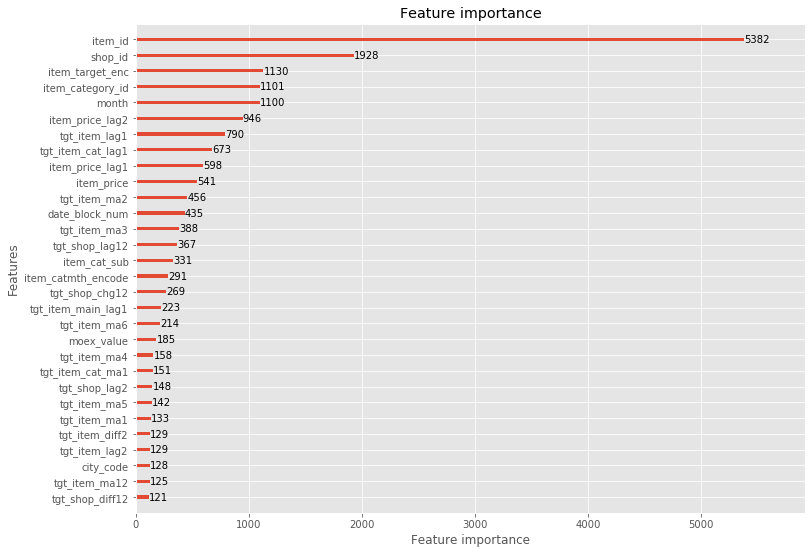

In [13]:
ax = lightgbm.plot_importance(model_lgb, importance_type = 'split', max_num_features = 30)
fig = ax.figure
fig.set_size_inches(12, 9)

In [ ]:
"""
4) XGBoost use categorical embeddings
5) KNN use categorical embeddings

These 2 models can 
Need to drop date_block_num
"""
random_seed = 23

x_train = emb_df[emb_df.date_block_num < 33].drop(['target'], axis=1)
y_train = emb_df[emb_df.date_block_num < 33]['target']
x_valid = emb_df[emb_df.date_block_num == 33].drop(['target'], axis=1)
y_valid = emb_df[emb_df.date_block_num == 33]['target']
x_test = emb_df[emb_df.date_block_num == 34].drop(['target'], axis=1)


del emb_df
gc.collect();

def rmse(y_pred, y):
    return np.sqrt(np.mean(np.square(y - y_pred)))
"""
4) XGBoost
"""
model_xgb = xgb.XGBRegressor(
                                learning_rate =0.05,
                                 n_estimators=500,
                                 max_depth=10,
#                                  min_child_weight=1,
                                 gamma=0.5,
                                 subsample=0.8,
                                 colsample_bytree=0.8,
                                 nthread=4,
                                 scale_pos_weight=1,
                                 seed=random_seed)

model_xgb.fit(x_train,y_train, 
              eval_set = [(x_train,y_train),(x_valid, y_valid)],
             eval_metric = 'rmse', 
             verbose = True, 
             early_stopping_rounds = 10)

xgb_pred = model_xgb.predict(x_test).clip(0, 20)
y_test = model_xgb.predict(x_test).clip(0, 20)


In [ ]:
ax = xgb.plot_importance(model_xgb)
fig = ax.figure
fig.set_size_inches(12, 25)

In [ ]:
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_test
})
submission.to_csv('submission_xgb_200722_001.csv', index=False) #1.0 

In [38]:
"""
1st-Level models using date_blocks [27, 28, 29, 30, 31, 32, 33] as validation

Tree based models
1) LightGBM with cat_df
2) Catboost with cat_df
3) LightGBM with emb_df

Linear models 
4) NN with emb_df
"""



"""
Cat data processing for models
"""

lgb_params  = {'boosting': 'gbdt', 
               'colsample_bytree': 0.8, 
               'feature_fraction': 0.8, 
               'learning_rate': 0.02, 
               'max_depth': 9, 
               'metric': 'rmse', 
               'min_child_samples': 15, 
               'num_leaves': 75, 
               'objective': 'regression', 
               'reg_alpha': 0.4, 
               'reg_lambda': 0.4, 
               'subsample': 0.3}

#Read data
cat_df = pd.read_pickle('AML Data Comp all_data 200726_trans_wtenc_wlags_seas.pkl')
cat_df = downcast_dtypes(cat_df)

#Get dates for cat_df
dates_cat = cat_df['date_block_num']

dates_cat_train  = dates_cat[dates_cat <  34]
dates_cat_test  = dates_cat[dates_cat == 34]

#Datasets which can handle categorical features natively 
drop_cols = list(cat_df.columns[cat_df.columns.str.contains('item_category_id_')]) + \
            list(cat_df.columns[cat_df.columns.str.contains('shop_id_')]) + \
            ['item_name', 'item_category_name'] 
cat_df = cat_df.drop(drop_cols, axis = 1)
# cat_cols = ['shop_id', 'item_id', 'item_category_id', 'month', 'year', 'quarter','city_code', 'item_cat_main']
cat_cols = ['shop_id', 'item_id', 'item_category_id', 'month', 'year', 'quarter','city_code', 'item_cat_main','item_cat_sub']
for col in cat_cols: 
    cat_df[col] = cat_df[col].astype(int)  
    
random_seed = 23
for c in cat_cols:
    cat_df[c] = cat_df[c].astype('category')

x_train = cat_df.loc[dates_cat <  34].drop(['target'], axis=1)
xc_test =  cat_df.loc[dates_cat == 34].drop(['target'], axis=1)

y_train = cat_df.loc[dates_cat <  34, 'target'].values
y_test =  cat_df.loc[dates_cat == 34, 'target'].values

dates_train_level2 = dates_cat_train[dates_cat_train.isin([27, 28, 29, 30, 31, 32, 33])]
y_train_level2 = y_train[dates_cat_train.isin([27, 28, 29, 30, 31, 32, 33])]

cat_col_ids = [x_train.columns.get_loc(k) for k in cat_cols]

x_train_level2 = np.zeros([y_train_level2.shape[0], 4])
print(x_train_level2.shape)
M= 15

for cur_block_num in [27, 28, 29, 30, 31, 32, 33]:
    print(cur_block_num)
    
    x_train_level2[dates_train_level2 == cur_block_num, 0] = cur_block_num
    
    M_dates = [d for d in list(dates_cat_train.unique()) if (d >= cur_block_num - M) & (d < cur_block_num)]
    train_data = x_train[dates_cat_train.isin(M_dates)]
    train_labels = y_train[dates_cat_train.isin(M_dates)]
    train_xtest = x_train[dates_cat_train == cur_block_num]
    train_ytest = y_train[dates_cat_train == cur_block_num]
    
    lgtrain = lightgbm.Dataset(train_data, label=train_labels)
    lgval = lightgbm.Dataset(train_xtest, label=train_ytest)
    
    model_lgb = lightgbm.train(lgb_params, lgtrain, 1000, 
                      valid_sets=[lgtrain, lgval], early_stopping_rounds=100, 
                      verbose_eval=100, )
    
    pred_lgb = model_lgb.predict(train_xtest.values).clip(0,20)
    lgbr2 = r2_score(train_ytest, pred_lgb)
    print(lgbr2)
    
    x_train_level2[dates_train_level2 == cur_block_num, 1] = pred_lgb
    
#     catboost_model = CatBoostRegressor(
#                             iterations=500,
#                             learning_rate = 0.02,
#                             max_ctr_complexity=5,
#                             loss_function = 'RMSE',
#                             od_type='Iter',
#                             od_wait=25,
#                             verbose=50,
#                             depth=4,
#                             random_seed = random_seed
#     )

#     catboost_model.fit(
#         train_data, train_labels,
#         cat_features=cat_col_ids,
#         eval_set=(train_xtest, train_ytest),
#         logging_level='Silent',
#         plot=True
#     )

#     pred_cat = catboost_model.predict(train_xtest).clip(0,20)
#     catr2 = r2_score(train_ytest, pred_cat)
#     print(catr2)
    
#     x_train_level2[dates_train_level2 == cur_block_num, 2] = pred_cat

del cat_df
x_train_level2[:100] 

(1614364, 4)
27
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.739452	valid_1's rmse: 0.803179
[200]	training's rmse: 0.686976	valid_1's rmse: 0.8059
Early stopping, best iteration is:
[141]	training's rmse: 0.708378	valid_1's rmse: 0.801196
0.42100534757051034
28
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.738753	valid_1's rmse: 0.726336
[200]	training's rmse: 0.684419	valid_1's rmse: 0.70844
[300]	training's rmse: 0.664781	valid_1's rmse: 0.709452
Early stopping, best iteration is:
[203]	training's rmse: 0.683721	valid_1's rmse: 0.707815
0.49982282843541526
29
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.730367	valid_1's rmse: 0.726222
[200]	training's rmse: 0.67652	valid_1's rmse: 0.712009
[300]	training's rmse: 0.657559	valid_1's rmse: 0.70933
[400]	training's rmse: 0.646606	valid_1's rmse: 0.706755
[500]	training's rmse: 0.637394	valid_1's rmse: 0.706246
[60

array([[27.        ,  0.0934781 ,  0.        ,  0.        ],
       [27.        ,  0.0934781 ,  0.        ,  0.        ],
       [27.        ,  0.14920861,  0.        ,  0.        ],
       [27.        ,  0.1262453 ,  0.        ,  0.        ],
       [27.        ,  0.33524257,  0.        ,  0.        ],
       [27.        ,  0.15192215,  0.        ,  0.        ],
       [27.        ,  0.03065343,  0.        ,  0.        ],
       [27.        ,  0.03065343,  0.        ,  0.        ],
       [27.        ,  0.03208212,  0.        ,  0.        ],
       [27.        ,  0.03208212,  0.        ,  0.        ],
       [27.        ,  0.03894891,  0.        ,  0.        ],
       [27.        ,  0.05914186,  0.        ,  0.        ],
       [27.        ,  0.03065343,  0.        ,  0.        ],
       [27.        ,  0.06600865,  0.        ,  0.        ],
       [27.        ,  0.04408167,  0.        ,  0.        ],
       [27.        ,  0.14859635,  0.        ,  0.        ],
       [27.        ,  0.

In [ ]:
x_train_level2[:,1].max()

In [39]:
"""
Emb data processing for models
"""

lgb_params  = {'boosting': 'gbdt', 
               'colsample_bytree': 0.8, 
               'feature_fraction': 0.8, 
               'learning_rate': 0.02, 
               'max_depth': 9, 
               'metric': 'rmse', 
               'min_child_samples': 15, 
               'num_leaves': 75, 
               'objective': 'regression', 
               'reg_alpha': 0.4, 
               'reg_lambda': 0.4, 
               'subsample': 0.3}

random_seed = 23

def root_mean_squared_error(y_true, y_pred):
            return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

#Read data
emb_df = pd.read_pickle('AML Data Comp all_data 200726_trans_wtenc_wlags_seas.pkl')
emb_df = downcast_dtypes(emb_df)

#Get dates for cat_df
dates_emb = emb_df['date_block_num']

dates_emb_train  = dates_emb[dates_emb <  34]
dates_emb_test  = dates_emb[dates_emb == 34]

#Datasets which cant handle categorical features natively
emb_df = emb_df.drop(['shop_id', 'item_id','item_category_id', 
                        'item_name', 'item_category_name', 
                         'year', 'month', 'quarter','item_cat_main',
                      'item_cat_sub','city_code'], axis = 1)

x_train = emb_df.loc[dates_emb <  34].drop(['target'], axis=1)
xe_test =  emb_df.loc[dates_emb == 34].drop(['target'], axis=1)

y_train = emb_df.loc[dates_emb <  34, 'target'].values
y_test =  emb_df.loc[dates_emb == 34, 'target'].values

dates_train_level2 = dates_emb_train[dates_emb_train.isin([27, 28, 29, 30, 31, 32, 33])]
y_train_level2 = y_train[dates_emb_train.isin([27, 28, 29, 30, 31, 32, 33])]



# x_train_level2 = np.zeros([y_train_level2.shape[0], 4])
print(x_train_level2.shape)
M= 15

for cur_block_num in [27, 28, 29, 30, 31, 32, 33]:
# for cur_block_num in [31]:
    print(cur_block_num)
    
    x_train_level2[dates_train_level2 == cur_block_num, 0] = cur_block_num

    
    M_dates = [d for d in list(dates_emb_train.unique()) if (d >= cur_block_num - M) & (d < cur_block_num)]
    train_data = x_train[dates_emb_train.isin(M_dates)]
    train_labels = y_train[dates_emb_train.isin(M_dates)]
    train_xtest = x_train[dates_emb_train == cur_block_num]
    train_ytest = y_train[dates_emb_train == cur_block_num]
    
    lgtrain = lightgbm.Dataset(train_data, label=train_labels)
    lgval = lightgbm.Dataset(train_xtest, label=train_ytest)
    
    model_lgbr = lightgbm.train(lgb_params, lgtrain, 1000, 
                      valid_sets=[lgtrain, lgval], early_stopping_rounds=100, 
                      verbose_eval=100, )
    
    pred_lgbr = model_lgbr.predict(train_xtest.values).clip(0,20)
    lgbrr2 = r2_score(train_ytest, pred_lgbr)
    print(lgbrr2)
    
    x_train_level2[dates_train_level2 == cur_block_num, 2] = pred_lgbr
    
    """
    NN
    Ridge Regression
    """

#     NAME = f"MetaNN_cat_lgb2"
#     tensorboard = TensorBoard(log_dir = f'logsMetaNN_1/{NAME}')

    train_data_arr = np.array(train_data)
#     train_data_arr = normalize(train_data_arr)
    
    train_xtest_arr = np.array(train_xtest)
#     train_xtest_arr = normalize(train_xtest_arr)
    
    lasso = Lasso(alpha = 1e-3, max_iter = 1000, random_state = random_seed)
    lasso.fit(train_data_arr, train_labels)
    pred_lass = lasso.predict(train_xtest_arr).clip(0,20)
    lassr2 = r2_score(train_ytest, pred_lass)
    print(lassr2)
    x_train_level2[dates_train_level2 == cur_block_num, 3] = pred_lass

#     nn = Sequential()
#     nn.add(Flatten())
#     nn.add(Dense(124, input_shape = (train_data_arr.shape[1],)))
#     nn.add(Activation(LeakyReLU(alpha=0.05)))
    
    
#     nn.add(Dense(124))
#     nn.add(Activation(LeakyReLU(alpha=0.05)))
#     nn.add(Dropout(0.2))
    
#     nn.add(Dense(1, kernel_initializer='he_normal'))
#     nn.add(Activation("linear"))

#     nn.compile(loss=root_mean_squared_error, optimizer='adam', metrics=[root_mean_squared_error])
#     nn.fit(x= train_data_arr,
#               y = train_labels, 
#                validation_data=(train_xtest_arr, train_ytest), epochs = 2, callbacks = [tensorboard])
    
    
    
#     pred_nn = nn.predict(train_xtest_arr).clip(0,20)
#     nnr2 = r2_score(train_ytest, pred_nn)
#     print(nnr2)
#     pred_nn = pred_nn.reshape(dates_train_level2[dates_train_level2 == cur_block_num].shape)
#     x_train_level2[dates_train_level2 == cur_block_num, 3] = pred_nn
    
del emb_df
x_train_level2[:100] 

(1614364, 4)
27
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.782103	valid_1's rmse: 0.784694
[200]	training's rmse: 0.740939	valid_1's rmse: 0.786997
Early stopping, best iteration is:
[130]	training's rmse: 0.763034	valid_1's rmse: 0.783191
0.48675226608499633
0.31699346358691227
28
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.780976	valid_1's rmse: 0.716458
[200]	training's rmse: 0.738762	valid_1's rmse: 0.705501
[300]	training's rmse: 0.722042	valid_1's rmse: 0.70372
[400]	training's rmse: 0.709914	valid_1's rmse: 0.701877
[500]	training's rmse: 0.700607	valid_1's rmse: 0.700137
[600]	training's rmse: 0.693553	valid_1's rmse: 0.699952
[700]	training's rmse: 0.687509	valid_1's rmse: 0.698635
[800]	training's rmse: 0.681991	valid_1's rmse: 0.697429
[900]	training's rmse: 0.677333	valid_1's rmse: 0.696059
[1000]	training's rmse: 0.672817	valid_1's rmse: 0.69498
Did not meet early stopping. Best iteratio

array([[2.70000000e+01, 9.34780967e-02, 1.00802041e-01, 3.95241944e-02],
       [2.70000000e+01, 9.34780967e-02, 1.00802041e-01, 4.34893241e-02],
       [2.70000000e+01, 1.49208609e-01, 1.39114129e-01, 3.82568732e-01],
       [2.70000000e+01, 1.26245305e-01, 1.23739358e-01, 2.93070650e-01],
       [2.70000000e+01, 3.35242574e-01, 3.24720043e-01, 8.55544340e-01],
       [2.70000000e+01, 1.51922154e-01, 1.75390030e-01, 2.68835963e-01],
       [2.70000000e+01, 3.06534256e-02, 3.51896231e-02, 0.00000000e+00],
       [2.70000000e+01, 3.06534256e-02, 3.51896231e-02, 0.00000000e+00],
       [2.70000000e+01, 3.20821240e-02, 3.70908798e-02, 0.00000000e+00],
       [2.70000000e+01, 3.20821240e-02, 3.70908798e-02, 0.00000000e+00],
       [2.70000000e+01, 3.89489086e-02, 4.46276263e-02, 0.00000000e+00],
       [2.70000000e+01, 5.91418623e-02, 6.96549003e-02, 9.08060743e-02],
       [2.70000000e+01, 3.06534256e-02, 3.51896231e-02, 0.00000000e+00],
       [2.70000000e+01, 6.60086469e-02, 7.71916468e

In [36]:
x_train_level2[:,1].max() 

0.0

In [ ]:
print(cur_block_num)

x_train_level2[dates_train_level2 == cur_block_num, 0] = cur_block_num


M_dates = [d for d in list(dates_emb_train.unique()) if (d >= cur_block_num - M) & (d < cur_block_num)]
train_data = x_train[dates_emb_train.isin(M_dates)]
train_labels = y_train[dates_emb_train.isin(M_dates)]
train_xtest = x_train[dates_emb_train == cur_block_num]
train_ytest = y_train[dates_emb_train == cur_block_num]

In [ ]:
nnr2

In [ ]:
pred_nn

In [ ]:
pred_nn.reshape(dates_train_level2[dates_train_level2 == cur_block_num].shape)

In [ ]:
dates_train_level2[dates_train_level2 == cur_block_num].shape

In [ ]:
num = 3
print(x_train_level2[:,num].mean())
print(x_train_level2[:,num].max())
print(x_train_level2[:,num].min())
print(x_train_level2[:,num].std())


In [ ]:
x_train_level2[:,[0,1,3]]

# 2nd level feature engineering

1) Pairwise differences between meta features <br>
2) Row-wise statistics (av, stds) <br>
3) Standard feature selection techniques <br>

In [40]:
"""
Create level 2 features
"""

x_train2 = pd.DataFrame(x_train_level2).rename(columns = \
                                               {0:'date_block_num',
                                               1:'lgbm_cat',
                                               2:'lgbm_emb',
                                               3:'lass_emb'})

# x_train2 = pd.DataFrame(x_train_level2[:,[0,1,3]]).rename(columns = \
#                                                {0:'date_block_num',
#                                                1:'lgbm_cat',
#                                                2:'lgbm_emb',})
                                              
x_train2['lgbmcat_lassemb'] = x_train2['lgbm_cat'] - x_train2['lass_emb'] 
x_train2['lgbmcat_lgbmemb'] = x_train2['lgbm_cat'] - x_train2['lgbm_emb']
x_train2['lassemb_lgbmemb'] = x_train2['lass_emb'] - x_train2['lgbm_emb']
x_train2['mean'] = x_train2.iloc[:,[1,2,3]].mean(axis = 1)
x_train2['std'] = x_train2.iloc[:,[1,2,3]].std(axis = 1)

print(x_train2.shape)
# x_train2.to_pickle('lgbmcat_lgbmemb_catcat_200725.pkl')
# x_train2.to_pickle('lgbmcat_lgbmemb_catcat_200725_002.pkl')
# x_train2.to_pickle('lgbmcat_lgbmemb_nnemb_200726_001.pkl')
x_train2.to_pickle('lgbmcat_lgbmemb_lassemb_200726_001.pkl')

x_train2

(1614364, 9)


,date_block_num,lgbm_cat,lgbm_emb,lass_emb,lgbmcat_lassemb,lgbmcat_lgbmemb,lassemb_lgbmemb,mean,std
0,27.0,0.093478,0.100802,0.039524,0.053954,-0.007324,-0.061278,0.077935,0.033466
1,27.0,0.093478,0.100802,0.043489,0.049989,-0.007324,-0.057313,0.079256,0.031191
2,27.0,0.149209,0.139114,0.382569,-0.233360,0.010094,0.243455,0.223630,0.137737
3,27.0,0.126245,0.123739,0.293071,-0.166825,0.002506,0.169331,0.181018,0.097048
4,27.0,0.335243,0.324720,0.855544,-0.520302,0.010523,0.530824,0.505169,0.303480
...,...,...,...,...,...,...,...,...,...
1614359,33.0,0.292837,0.253274,0.555274,-0.262437,0.039563,0.302000,0.367128,0.164135
1614360,33.0,0.115705,0.098181,0.158874,-0.043169,0.017524,0.060693,0.124253,0.031237
1614361,33.0,0.195221,0.196405,0.359385,-0.164164,-0.001184,0.162980,0.250337,0.094440
1614362,33.0,0.043559,0.023584,0.013511,0.030049,0.019975,-0.010073,0.026885,0.015294


# 2nd level models
1) Alpha aggregation <br>
OR  <br>
2) Small depth gradient boosting (2/3 depth) <br>
3) Linear model with high regularization <br>
4) Shallow NN (1 layer) <br>


In [ ]:
alphas_to_try = np.linspace(0, 1, 1001)

def mix_preds(alpha):
    return alpha * x_train_level2[:, 1] + (1 - alpha)*x_train_level2[:, 2]

r_scores = [r2_score(y_train_level2, mix_preds(alpha)) for alpha in alphas_to_try]
best_alpha = alphas_to_try[np.argmax(r_scores)]
r2_train_simple_mix = r2_score(y_train_level2, mix_preds(best_alpha))
print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))

In [ ]:
lgb_test = model_lgb.predict(x_test)
cat_test = catboost_model.predict(x_test)

def mix_test(alpha):
    return alpha * lgb_test + (1 - alpha)*cat_test

y_test = mix_test(best_alpha)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_test
})
submission.to_csv('submission_cat_lgb_remix_200723_001.csv', index=False) #0.99725


In [ ]:
x_train2.shape[1]

In [42]:
"""
Linear model aggregation
NN model aggregation
"""


metalr = LinearRegression()
metalr.fit(x_train2.drop('date_block_num', axis = 1), y_train_level2)

# def root_mean_squared_error(y_true, y_pred):
#         return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

# NAME = f"MetaNN_cat_lgb2"
# tensorboard = TensorBoard(log_dir = f'logsMetaNN_1/{NAME}')

# x_train2_arr = np.array(x_train2.drop('date_block_num',axis=1))
# x_train2_arr = normalize(x_train2_arr)

# metann = Sequential()
# metann.add(Flatten())
# metann.add(Dense(124, input_shape = (x_train2_arr.shape[1],)))
# metann.add(Activation(LeakyReLU(alpha=0.05)))
# metann.add(Dense(1, kernel_initializer='he_normal'))
# metann.add(Activation("linear"))


# metann.compile(loss=root_mean_squared_error, optimizer='SGD', metrics=[root_mean_squared_error])
# metann.fit(x= x_train2_arr,
#           y = y_train_level2, epochs = 10, callbacks = [tensorboard])


lgbcat_test = model_lgb.predict(xc_test).clip(0,20)
print(f'lgbcat_test shape: {lgbcat_test.shape}')
lass_test = np.array(lasso.predict(np.array(xe_test)).reshape(xe_test.shape[0],).clip(0,20))
print(f'lass_test shape: {lass_test.shape}')
lgbemb_test = model_lgbr.predict(xe_test).clip(0,20)
print(f'lgbemb_test shape: {lgbemb_test.shape}')

lincombined = np.vstack([lgbcat_test, lass_test, lgbemb_test]).T
x_test = pd.DataFrame(lincombined)
# x_test.rename(columns = \
#                        {0:'lgbm_cat',
#                        1:'catboost_cat',
#                        2:'lgbm_emb'}, inplace = True)
x_test.rename(columns = \
                       {0:'lgbm_cat',
                        1:'lgbm_emb',
                        2:'lass_emb'}, inplace = True)
x_test['lgbmcat_nnemb'] = x_test['lgbm_cat'] - x_test['lass_emb'] 
x_test['lgbmcat_lgbmemb'] = x_test['lgbm_cat'] - x_test['lgbm_emb']
x_test['lassemb_lgbmemb'] = x_test['lass_emb'] - x_test['lgbm_emb']
x_test['mean'] = x_test.iloc[:,[0,1,2]].mean(axis = 1)
x_test['std'] = x_test.iloc[:,[0,1,2]].std(axis = 1)

# x_test_arr = np.array(x_test)
# x_test_arr = normalize(x_test)

y_test = metalr.predict(x_test).clip(0,20)
y_test = y_test.reshape(y_test.shape[0],)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_test
})

# submission.to_csv('submission_cat_lgb2_remix_200725_001.csv', index=False) #0.98395
# submission.to_csv('submission_cat_lgb2_remix_200725_002.csv', index=False) #1.24754
# submission.to_csv('submission_cat_lgb2_remix_200725_003.csv', index=False) #1.24754
# submission.to_csv('submission_nn_lgb2_remix_200726_001.csv', index=False) #1.24754
submission.to_csv('submission_lass_lgb2_remix_200727_001.csv', index=False) #1.02

y_test

lgbcat_test shape: (214200,)
lass_test shape: (214200,)
lgbemb_test shape: (214200,)


array([1.08023941, 0.09075653, 1.30943787, ..., 0.02360308, 0.        ,
       0.08132637])

In [43]:
submission.iloc[3000:3100]

,ID,item_cnt_month
3000,3000,0.053142
3001,3001,0.000000
3002,3002,0.029492
3003,3003,0.000000
3004,3004,0.197673
3005,3005,0.058557
3006,3006,0.058613
3007,3007,0.000000
3008,3008,0.000000
3009,3009,0.000000


In [ ]:
lgbcat_test.shape

In [ ]:
submission['item_cnt_month'].std()

In [ ]:
submission['item_cnt_month'].max()

In [ ]:
x_test

In [ ]:
submission

In [ ]:
# 2nd level models
1) Alpha aggregation <br>



In [ ]:
"""
Hyperopt template
"""
lgb_params = {'boosting': 'gbdt',
             'colsample_bytree': 0.7,
             'feature_fraction': 0.7,
             'learning_rate': 0.02,
             'max_depth': 8,
             'metric': 'rmse',
             'min_child_samples': 20,
             'num_leaves': 50,
             'objective': 'regression',
             'reg_alpha': 0.3,
             'reg_lambda': 0.3,
             'subsample': 0.3, 
             'seed':random_seed}

# # Define searched space
# hyper_space = {'objective': 'regression',
#                'metric':'rmse',
#                'boosting':'gbdt',
# #                'n_estimators': hp.choice('n_estimators', [100, 250, 500]),
#                'max_depth':  hp.choice('max_depth', [8, 9,10,11]),
#                'num_leaves': hp.choice('num_leaves', [50, 60, 75]),
#                'subsample': hp.choice('subsample', [.2,.3,.4, .5]),
#                'colsample_bytree': hp.choice('colsample_bytree', [.6,.7,.8]),
#                'learning_rate': hp.choice('learning_rate', [.01,.02, .03,.05]),
#                'reg_alpha': hp.choice('reg_alpha', [.3, .4, .5]),
#                'reg_lambda':  hp.choice('reg_lambda', [.3, .4, .5]), 
#                 # 'bagging_fraction': hp.choice('bagging_fraction', [.5, .6, .7, .8, .9, 1]),
#                'feature_fraction':  hp.choice('feature_fraction', [.6, .7,.8]), 
# #                'bagging_frequency':  hp.choice('bagging_frequency', [.3, .4, .5, .6, .7, .8, .9]),                  
#                'min_child_samples': hp.choice('min_child_samples', [15, 20,25, 30])}





# lgtrain = lightgbm.Dataset(x_train, label=y_train)
# lgval = lightgbm.Dataset(x_valid, label=y_valid)

# def evaluate_metric(params):
    
#     model_lgb = lightgbm.train(params, lgtrain, 1000, 
#                           valid_sets=[lgtrain, lgval], early_stopping_rounds=100, 
#                           verbose_eval=300, categorical_feature = 'auto')

#     pred = model_lgb.predict(x_valid, num_iteration=1000)

#     score = rmse(pred, y_valid)
    
#     print(score, params)
 
#     return {
#         'loss': score,
#         'status': STATUS_OK,
#         'stats_running': STATUS_RUNNING
#     }

# # Trail
# trials = Trials()

# # Set algoritm parameters
# algo = partial(tpe.suggest, 
#                n_startup_jobs=-1)

# # Seting the number of Evals
# MAX_EVALS= 200

# # Fit Tree Parzen Estimator
# best_vals = fmin(fn=evaluate_metric, space=hyper_space, verbose=1,
#                  algo=algo, max_evals=MAX_EVALS, trials=trials)

# # Print best parameters
# best_params = space_eval(hyper_space, best_vals)

"""
Catboost hyperopt
"""

# # Define searched space
# hyper_space = {'iterations':500,
#                'max_ctr_complexity': hp.choice('max_ctr_complexity', [4,5,6]),
#                'random_seed':23,
#                 'learning_rate' = hp.choice('max_ctr_complexity', [.01,.02,.05,.1])
#                'od_type':'Iter',
#                'od_wait':25,
#                'verbose':50,
#                'depth': hp.choice('depth', [4,5,6])}

# def evaluate_metric(params):
    
#     catboost_model = CatBoostRegressor(**params)
#     model_cat = catboost_model.fit(x_train, y_train, 
#                           eval_set=(x_valid, y_valid), cat_features = cat_cols)

#     pred = model_cat.predict(x_valid)

#     score = rmse(pred, y_valid)
    
#     print(score, params)
 
#     return {
#         'loss': score,
#         'status': STATUS_OK,
#         'stats_running': STATUS_RUNNING
#     }

# # Trial
# trials = Trials()

# # Set algoritm parameters
# algo = partial(tpe.suggest, 
#                n_startup_jobs=-1)

# # Seting the number of Evals
# MAX_EVALS= 200

# # Fit Tree Parzen Estimator
# best_vals = fmin(fn=evaluate_metric, space=hyper_space, verbose=1,
#                  algo=algo, max_evals=MAX_EVALS, trials=trials)

# # Print best parameters
# best_params = space_eval(hyper_space, best_vals)